In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
df = pd.read_csv('../data/raw/structure_projects.csv', sep=';')

In [3]:
df.info(150)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22636 entries, 0 to 22635
Data columns (total 106 columns):
 #    Column                             Dtype  
---   ------                             -----  
 0    Unnamed: 0                         int64  
 1    floor_name                         object 
 2    version                            object 
 3    project_code                       object 
 4    floor_code                         object 
 5    software                           object 
 6    slab_type                          object 
 7    depth                              float64
 8    floor_number                       int64  
 9    total_height                       float64
 10   level                              float64
 11   height                             float64
 12   floor_max_height                   float64
 13   floor_min_height                   float64
 14   foundation_height                  float64
 15   max_height_all_floors              float64
 16   mi

# Data cleaning

Data cleaning is divided by group of variables but the target one that is considered alone.

In [4]:
df.drop(columns='Unnamed: 0', inplace=True)

## Target variable (reinf_steel_ratio)

Primero imprimimos el histograma para ver la distribución de la variable, la cual se aprecia que no sigue una distribución normal:

<AxesSubplot: xlabel='reinf_steel_ratio', ylabel='Count'>

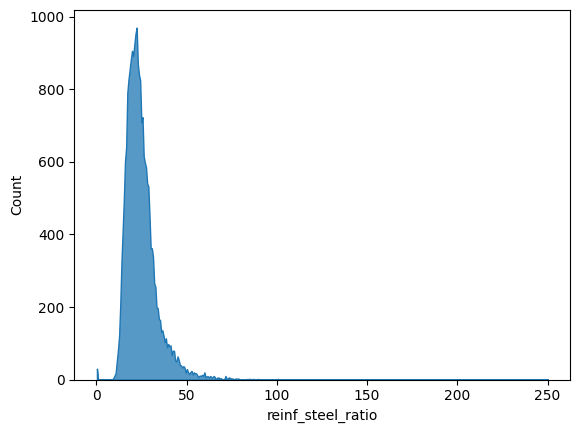

In [5]:
sns.histplot(df, x="reinf_steel_ratio", element="poly")

<AxesSubplot: xlabel='concrete_m3_ratio', ylabel='Count'>

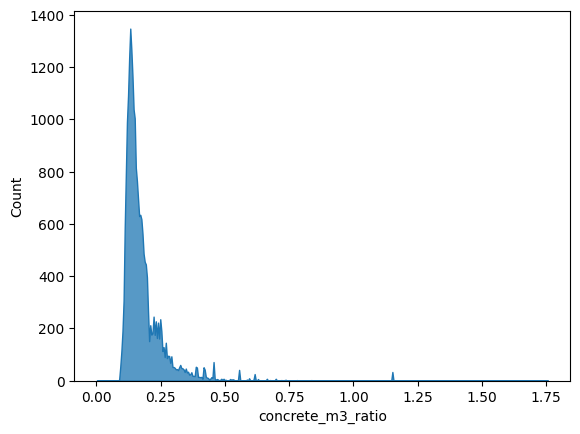

In [6]:
sns.histplot(df, x="concrete_m3_ratio", element="poly")

Al mostrar el boxplot se pueden identificar fácilmente que hay muchos outliers.

<AxesSubplot: xlabel='reinf_steel_ratio'>

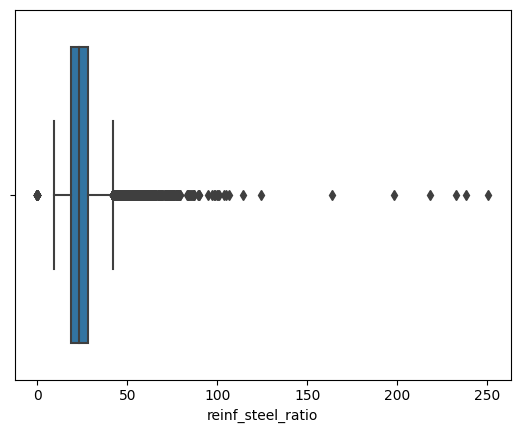

In [7]:
sns.boxplot(x=df["reinf_steel_ratio"])

Como no sigue una distribuión normal se ha empleado la técnica de intercuantil para identificar los outliers. Hay 30 outliers por debajo de 5 kg/m2 y 1040 por encima de 41 kg/m2, en total 1070.

In [8]:
def find_min_max_outliers_IQR(serie):
    q1 = serie.quantile(0.25)
    q3 = serie.quantile(0.75)
    IQR = q3-q1
    return q1-1.5*IQR, q3+1.5*IQR

# outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

In [9]:
min_, max_ = find_min_max_outliers_IQR(df['reinf_steel_ratio'])
min_, max_

(5.180000000000007, 41.81999999999999)

In [10]:
min_outliers = df['reinf_steel_ratio'] < min_
max_outliers = df['reinf_steel_ratio'] > max_

print(f"Num min outliers: {min_outliers.sum()}")
print(f"Num max outliers: {max_outliers.sum()}")

Num min outliers: 30
Num max outliers: 1040


Los outliers por debajo son todos 0:

In [11]:
df.loc[min_outliers, ['reinf_steel_ratio']]

,reinf_steel_ratio
9629,0.0
9630,0.0
9631,0.0
9632,0.0
9633,0.0
9634,0.0
9635,0.0
9636,0.0
9637,0.0
9638,0.0


Todos recaen en sólo 2 proyectos, por tanto, se procederá a eliminarlos del dataset.

In [12]:
df.loc[min_outliers, 'project_code'].unique()

array(['BOSC18025_C09_I02_H05_Q04_R09_V13_S03_O01',
       'PYAS20202_C02_I02_H00_Q05_R01_V12_S00_O02'], dtype=object)

In [13]:
def get_non_reinf_steel_ratio_project_codes(df):
    aux = df.groupby(by='project_code')['reinf_steel_ratio'].sum()
    return aux[aux == 0].index.tolist()

In [14]:
project_codes = get_non_reinf_steel_ratio_project_codes(df)
project_codes

['BOSC18025_C09_I02_H05_Q04_R09_V13_S03_O01',
 'PYAS20202_C02_I02_H00_Q05_R01_V12_S00_O02']

In [15]:
df = df.loc[~df['project_code'].isin(project_codes), :]

Los outliers por arriba llegan a ser muy grandes. Tipos de errores:

- Baile de números: PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01 imputa 232.52	y debería ser 32.52.

In [16]:
max_outliersproject_codes = df.loc[max_outliers, 
       ['project_code', 'reinf_steel_ratio']].sort_values(by='reinf_steel_ratio', 
                                                          ascending=False)['project_code'].unique()

<AxesSubplot: >

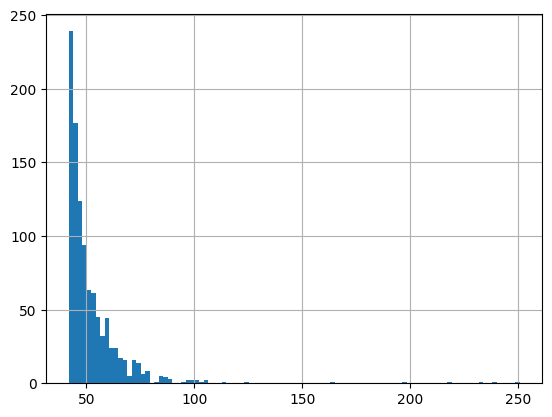

In [17]:
df.loc[max_outliers, 'reinf_steel_ratio'].hist(bins=100)

In [19]:
base_fields = ['project_code', 'floor_name', 'reinf_steel_ratio', 'concrete_m3_ratio', 'slab_type', 
               'slab_total_area', 'level', 'height']
load_fields = ['LL', 'DL', 'LL_max', 'DL_max', 'wind_load_x', 'wind_load_y', 'seismic_acc']
areas = ['flat_slab_area', 'waffle_slab_area', 'drop_panel_area', 'domes_area', 
         'support_area','stair_area', 'slope_area', 'walls_area', 'retaining_walls_area',]
fields = [ 'total_height', 'level', 'height']

- Varias plantas con muchos kg/m2: PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01, PYAS20205M1_C06_I01_H05_Q02_R03_V07_S00_O01, BOSC19216_C07_I02_H05_Q06_R09_V13_S03_O01, PYAS20205M1_C04_I02_H04_Q05_R04_V07_S00_O01, BOSC19216_C05_I03_H15_Q07_R08_V13_S03_O01, BOSC19216_C11_I02_H05_Q07_R08_V13_S03_O01, BOSC20205M1_C08_I03_H06_Q01_R03_V13_S03_O01, PYAS20205M1_C09_I01_H15_Q06_R02_V07_S00_O01
- Sotanos con muchos kg/m2: PYAS19018_C00_I00_H00_Q00_R00_V00_S00_O01, PYAS18008_C00_I00_H00_Q00_R00_V00_S00_O01, BOLP18010_C00_I00_H00_Q00_R00_V00_S00_O01, PYAS19004M1_C00_I00_H00_Q00_R00_V00_S00_O01, PYAS20028_C00_I00_H00_Q00_R00_V00_S00_O01, BOLP17016_C00_I00_H00_Q00_R00_V00_S00_O01
- Error de entrada: PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01 (232.52 -> 32.52)
- Dobles alturas: área muy pequeña: 87m2 y 114kg/m2 con muros de contención a doble altura? BOSC18012_C00_I00_H00_Q00_R00_V00_S00_O01. Este igual BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01 doble altura sin retaining wall 50kg/m2. PYAS17010_C00_I00_H00_Q00_R00_V00_S00_O01 (99.64 kg/m2). PYAS21003_C00_I00_H00_Q00_R00_V00_S00_O01, BOLP18008_C00_I00_H00_Q00_R00_V00_S00_O01.
- Edificio cortado, BOLP17014M2_C02_I02_H12_Q01_R03_V07_S02_O01 empieza planta 2, área pequeña (34m2) sin doble altura. BOLP17014M2_C01_I01_H11_Q02_R04_V06_S01_O01
- Forjados muy pequeños: PYAS20020_C00_I00_H00_Q00_R00_V00_S00_O02
- Grandas cargas como:
    - piscina: DL_max de 26 y 103.81 kg/m2 en PYAS19031_C00_I00_H00_Q00_R00_V00_S00_O02
    - depósito de agua: en BOLP16027_C00_I00_H00_Q00_R00_V00_S00_O01, BOSC16009_C00_I00_H00_Q00_R00_V00_S00_O01, PYAS20004_C00_I00_H00_Q00_R00_V00_S00_O02
    - Tapa tanque más kg/m2 que base!! PYAS19022_C00_I00_H00_Q00_R00_V00_S00_O01.
- Forjados tipo FLAT_SLAB que deberían ser FOAM_WAFFLE (PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01)
- Forjados con área 0 (PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01)

In [673]:
df[df['project_code'] == 'PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01'][base_fields+load_fields]

,project_code,floor_name,reinf_steel_ratio,concrete_m3_ratio,slab_type,slab_total_area,level,height,LL,DL,LL_max,DL_max,wind_load_x,wind_load_y,seismic_acc


In [21]:
intra_outliers = []
for i in range(len(max_outliersproject_codes)):
    aux = df[df['project_code'] == max_outliersproject_codes[i]]
    min_, max_ = find_min_max_outliers_IQR(aux['reinf_steel_ratio'])
    outliears_floors = aux[(aux['reinf_steel_ratio'] <= min_) | (aux['reinf_steel_ratio'] > max_)]
    if len(outliears_floors) > 0:
        intra_outliers.append(outliears_floors)

In [22]:
len(intra_outliers)

251

In [23]:
fields = ['depth', 'floor_number', 'total_height', 'level', 'height',
       'floor_max_height', 'floor_min_height', 'foundation_height',
       'max_height_all_floors', 'min_height_all_floors', 'support_column',
       'unsupported_column', 'walls_number', 'retaining_walls_number',
       'inter_axis_distance', 'LL', 'DL', 'LL_max', 'DL_max', 'wind_load_x',
       'wind_load_y', 'seismic_acc', 'total_area', 'double_height',
       'flat_slab_area', 'waffle_slab_area', 'drop_panel_area', 'domes_area',
       'support_area', 'shape_factor', 'x_length', 'y_length', 'stair_area',
       'slope_area', 'walls_area', 'retaining_walls_area', 'concrete_m3_ratio',
       'reinf_steel_ratio', 'struc_steel_ratio', 'domes_number']

In [686]:
out_min_max = {f: find_min_max_outliers_IQR(df[df[f] > 0][f]) for f in fields}

TypeError: '>' not supported between instances of 'str' and 'int'

In [25]:
out_min_max['DL_max']

(1.25, 3.25)

In [33]:
aux = intra_outliers[1]
for i, r in aux.iterrows():
    print(f"{r['floor_name']} ({r['slab_type']})")
    for f, (min_, max_) in out_min_max.items():
        if r[f] != 0 and r[f] < min_ or r[f] > max_:
            print(f"\t{f}: {round(r[f],1)} ({round(min_,1)}, {round(max_,1)})")

Planta Baja Inf (FOAM_WAFFLE)
	foundation_height: -2.5 (0.0, 1.6)
	DL_max: 5.0 (1.2, 3.2)
	support_area: 29.4 (-7.5, 23.2)
	walls_area: 27.3 (-6.7, 14.4)
	concrete_m3_ratio: 1.0 (0.0, 0.3)
	reinf_steel_ratio: 114.0 (5.2, 41.8)
Casetón ascensor (FLAT_SLAB)
	height: 1.4 (2.0, 4.0)
	floor_max_height: 1.4 (2.0, 4.0)
	floor_min_height: 1.4 (2.0, 4.0)
	foundation_height: -2.5 (0.0, 1.6)
	DL: 2.5 (2.0, 2.0)
	concrete_m3_ratio: 0.5 (0.0, 0.3)
	reinf_steel_ratio: 63.8 (5.2, 41.8)


In [34]:
out_min_max

{'depth': (0.19500000000000003, 0.395),
 'floor_number': (-6.5, 37.5),
 'total_height': (-21.899999999999995, 108.74),
 'level': (-25.214999999999996, 67.625),
 'height': (2.0, 4.0),
 'floor_max_height': (2.0, 4.0),
 'floor_min_height': (2.0, 4.0),
 'foundation_height': (2.220446049250313e-16, 1.5999999999999999),
 'max_height_all_floors': (1.825000000000001, 5.624999999999998),
 'min_height_all_floors': (0.5, 4.5),
 'support_column': (-12.0, 52.0),
 'unsupported_column': (-11.0, 21.0),
 'walls_number': (-7.5, 20.5),
 'retaining_walls_number': (-3.5, 16.5),
 'inter_axis_distance': (0.7324999999999999, 0.8725),
 'LL': (0.5, 4.5),
 'DL': (2.0, 2.0),
 'LL_max': (-1.0, 7.0),
 'DL_max': (1.25, 3.25),
 'wind_load_x': (-53.160624999999996, 179.080375),
 'wind_load_y': (-70.96675000000002, 216.72725000000003),
 'seismic_acc': (1.1379599999999999, 2.07972),
 'total_area': (-267.56641866249936, 1197.065588797499),
 'double_height': (-318.54292367069127, 531.3484236788854),
 'flat_slab_area': (-2

## Forjados (slabs)

Hay 2 tipos de forjados. 'FOAM_WAFFLE', 'FLAT_SLAB'

In [34]:
sf = ['slab_type', 'slab_total_area', 'depth']
ff = ['flat_slab_area']
wf = ['inter_axis_distance', 'waffle_slab_area', 'drop_panel_area', 'domes_area', 'domes_number']

In [35]:
df['slab_type'].unique()

array(['FOAM_WAFFLE', 'FLAT_SLAB'], dtype=object)

<AxesSubplot: xlabel='slab_type'>

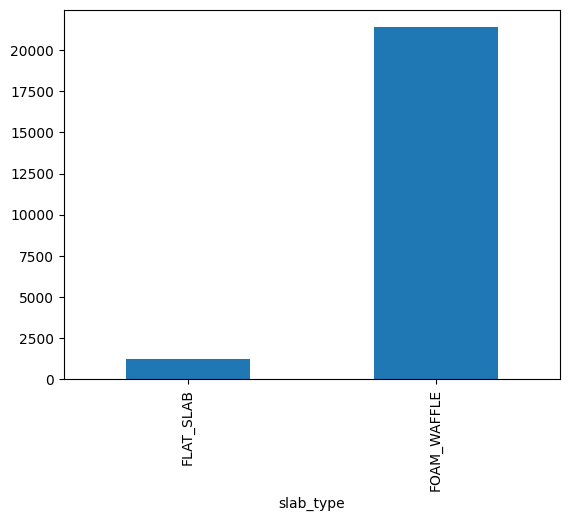

In [36]:
df.groupby(by='slab_type')['slab_type'].count().plot(kind='bar')

In [37]:
(df['slab_total_area'] != df['flat_slab_area'] + df['waffle_slab_area']).sum()

0

In [38]:
df[df['slab_total_area'] <= 0][['project_code']+sf+ff+wf]

,project_code,slab_type,slab_total_area,depth,flat_slab_area,inter_axis_distance,waffle_slab_area,drop_panel_area,domes_area,domes_number
20648,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01,FLAT_SLAB,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0


In [39]:
df[df['project_code'] == 'PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01']

,floor_name,version,project_code,floor_code,software,slab_type,depth,floor_number,total_height,level,...,cantilever_mean_dist,cantilever_max_dist,cantilever_min_dist,cantilever_area,span_dists,cantilever_dists,center_x,center_y,slab_total_area,ignored
20645,SS-1,2.4.0,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01_F0,CYPE,FOAM_WAFFLE,0.31,17,57.55,-2.45,...,2.779136,8.410878,0.034997,368.499196,"[[8.980828049737418, 8.980828049737418, 8.8285...","[[0.13817665094535175, 0.150566102318777, 2.78...",41.9956,33.618114,1012.110408,NO
20646,PB,2.4.0,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01_F1,CYPE,FOAM_WAFFLE,0.31,17,57.55,1.30,...,3.148657,8.410878,0.034997,414.488501,"[[8.980828049737418, 8.980828049737418, 8.8285...","[[0.13817665094535175, 0.150566102318777, 2.78...",41.9956,33.618114,1055.817501,NO
20647,P01,2.4.0,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01_F2,CYPE,FOAM_WAFFLE,0.31,17,57.55,5.05,...,1.030587,6.174921,0.034997,103.362488,"[[8.998809425836699, 8.998809425836699, 8.1702...","[[0.06186866924389329, 0.11507026282200172, 0....",29.6957,20.997200,447.166555,NO
20648,P02,2.4.0,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01_F3,CYPE,FLAT_SLAB,0.20,17,57.55,8.80,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.000000,0.000000,NO
20649,P03,2.4.0,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01_F4,CYPE,FOAM_WAFFLE,0.31,17,57.55,12.55,...,1.159872,6.461914,0.034997,63.887334,"[[9.111024908662168, 9.111024908662168, 9.0920...","[[0.3721881486950337, 0.6432106944018984, 0.26...",29.6957,20.997200,472.912426,NO
20650,P04,2.4.0,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01_F5,CYPE,FOAM_WAFFLE,0.31,17,57.55,16.30,...,1.193381,6.461914,0.034997,59.039866,"[[9.129986319956203, 9.129986319956203, 9.0920...","[[0.3469834481896419, 0.6083501048155371, 0.25...",29.6957,20.997200,472.912288,NO
20651,P05,2.4.0,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01_F6,CYPE,FOAM_WAFFLE,0.31,17,57.55,20.05,...,1.170067,6.461914,0.034997,85.077006,"[[9.148976747096492, 9.148976747096492, 9.1299...","[[0.34680014652525687, 0.5876603904744325, 0.2...",29.6957,20.997200,472.892835,NO
20652,P06,2.4.0,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01_F7,CYPE,FOAM_WAFFLE,0.31,17,57.55,23.80,...,1.138478,6.461914,0.034997,96.446203,"[[9.167999945982933, 9.167999945982933, 9.1679...","[[0.3215951032377513, 0.5527140943759867, 0.21...",29.6957,20.997200,484.128041,NO
20653,P07,2.4.0,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01_F8,CYPE,FOAM_WAFFLE,0.31,17,57.55,27.55,...,0.992876,6.789750,0.031510,28.161541,"[[9.187043928901291, 9.187043928901291, 9.1679...","[[0.14900161821132496, 0.34752417936994867, 0....",29.6957,20.997200,470.275643,NO
20654,P08,2.4.0,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01,PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01_F9,CYPE,FOAM_WAFFLE,0.31,17,57.55,31.30,...,1.144815,6.461914,0.034997,43.279409,"[[9.206124243799886, 9.206124243799886, 9.2061...","[[0.14900161821132496, 0.34752417936994867, 0....",29.6957,20.997200,484.128000,NO


In [40]:
df[df['project_code'] == 'PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01'][sf+ff+wf]

,slab_type,slab_total_area,depth,flat_slab_area,inter_axis_distance,waffle_slab_area,drop_panel_area,domes_area,domes_number
20645,FOAM_WAFFLE,1012.110408,0.31,0.0,0.82,1012.110408,391.566064,646.8488,962
20646,FOAM_WAFFLE,1055.817501,0.31,0.0,0.82,1055.817501,375.136884,706.6924,1051
20647,FOAM_WAFFLE,447.166555,0.31,0.0,0.82,447.166555,95.738783,336.2000,500
20648,FLAT_SLAB,0.000000,0.20,0.0,0.00,0.000000,0.000000,0.0000,0
20649,FOAM_WAFFLE,472.912426,0.31,0.0,0.82,472.912426,97.714524,361.0788,537
20650,FOAM_WAFFLE,472.912288,0.31,0.0,0.82,472.912288,97.025106,361.0788,537
20651,FOAM_WAFFLE,472.892835,0.31,0.0,0.82,472.892835,95.678633,362.4236,539
20652,FOAM_WAFFLE,484.128041,0.31,0.0,0.82,484.128041,95.328587,375.1992,558
20653,FOAM_WAFFLE,470.275643,0.31,0.0,0.82,470.275643,93.277088,360.4064,536
20654,FOAM_WAFFLE,484.128000,0.31,0.0,0.82,484.128000,93.335673,375.8716,559


In [41]:
def get_non_slab_total_area(df):
    return df[df['slab_total_area'] <= 0]['project_code'].unique().tolist()

In [42]:
projects_no_slab_area = get_non_slab_total_area(df)
projects_no_slab_area

['PYAS20205M1_C07_I02_H06_Q04_R08_V07_S00_O01']

In [43]:
df = df.loc[~df['project_code'].isin(projects_no_slab_area), :]

No se detectan plantas con los dos tipos de forjados.

In [44]:
df[(df['flat_slab_area'] > 0) & (df['waffle_slab_area'])][['project_code']+sf+ff+wf]

,project_code,slab_type,slab_total_area,depth,flat_slab_area,inter_axis_distance,waffle_slab_area,drop_panel_area,domes_area,domes_number


<AxesSubplot: xlabel='slab_total_area', ylabel='slab_type'>

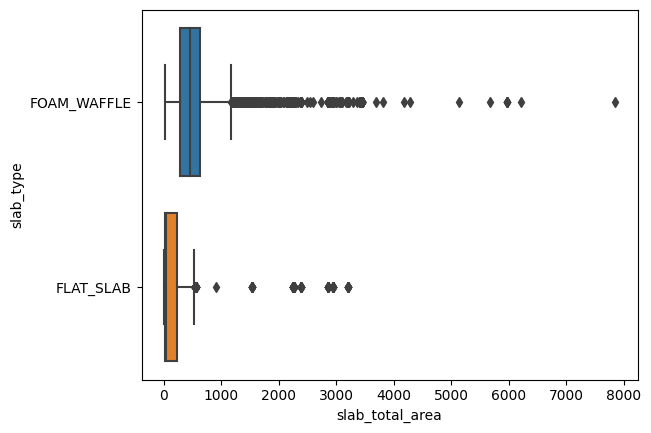

In [45]:
sns.boxplot(df, x='slab_total_area', y='slab_type')

<AxesSubplot: xlabel='slab_total_area', ylabel='Count'>

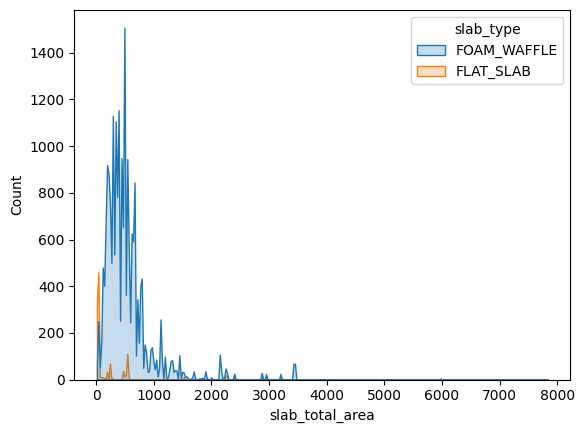

In [46]:
sns.histplot(data=df, x="slab_total_area", hue="slab_type", element="poly")

<AxesSubplot: xlabel='flat_slab_area', ylabel='Count'>

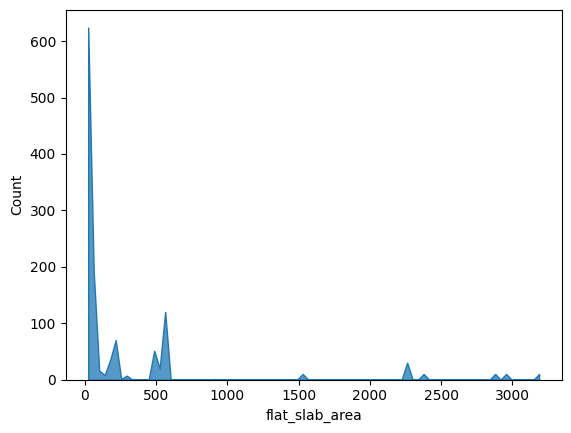

In [47]:
sns.histplot(data=df[df['flat_slab_area'] > 0], x="flat_slab_area", element="poly")

In [48]:
min_, max_ = find_min_max_outliers_IQR(df[df['flat_slab_area'] > 0]['flat_slab_area'])
min_, max_

(-284.8956150076632, 544.325155948598)

In [49]:
find_min_max_outliers_IQR(df.loc[df['flat_slab_area'] > 0, 'flat_slab_area'])

(-284.8956150076632, 544.325155948598)

<AxesSubplot: xlabel='flat_slab_area'>

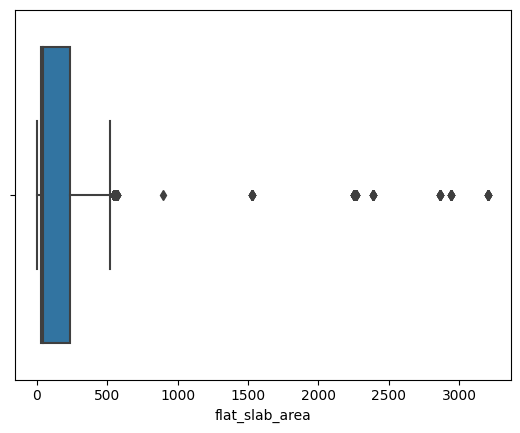

In [50]:
sns.boxplot(x=df.loc[df['flat_slab_area'] > 0, 'flat_slab_area'])

<AxesSubplot: xlabel='flat_slab_area', ylabel='Count'>

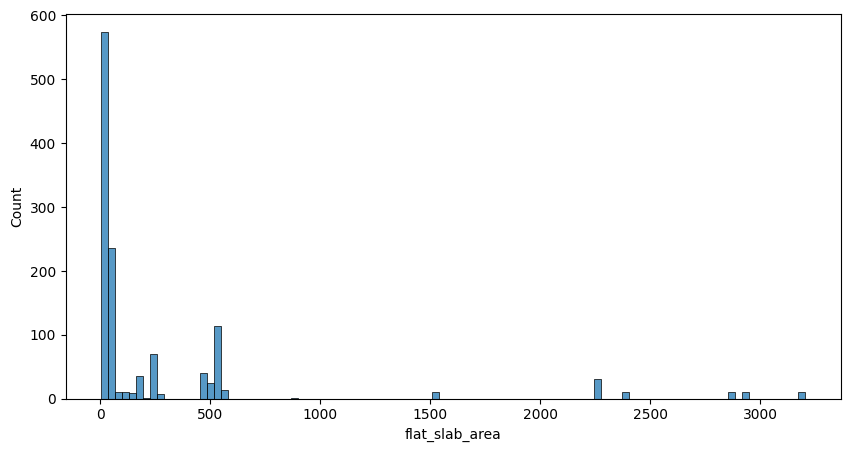

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ax=ax, data=df.loc[df['flat_slab_area'] > 0, ['flat_slab_area']], x="flat_slab_area", bins=100)

In [52]:
df[(df['flat_slab_area'] > 350) & (df['flat_slab_area'] < 600)][base_fields+load_fields]

,project_code,floor_name,reinf_steel_ratio,concrete_m3_ratio,slab_type,slab_total_area,level,height,LL,DL,LL_max,DL_max,wind_load_x,wind_load_y,seismic_acc
15355,PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01,EP,232.52,0.264480,FLAT_SLAB,490.748004,5.76,2.96,2.0,2.0,3.0,3.0,47.007,82.756,0.0
19420,PYAS20033_C02_I01_H05_Q06_R07_V10_S00_O01,P07,43.05,0.309343,FLAT_SLAB,473.077289,25.82,3.50,3.0,2.0,3.0,2.0,163.034,163.034,0.0
19421,PYAS20033_C02_I01_H05_Q06_R07_V10_S00_O01,P08,41.00,0.308580,FLAT_SLAB,473.061337,29.32,3.50,3.0,2.0,3.0,2.0,172.072,172.072,0.0
19422,PYAS20033_C02_I01_H05_Q06_R07_V10_S00_O01,P09,37.54,0.297482,FLAT_SLAB,517.313137,32.82,3.50,3.0,2.0,3.0,2.0,180.297,180.297,0.0
19423,PYAS20033_C02_I01_H05_Q06_R07_V10_S00_O01,P10,34.44,0.293206,FLAT_SLAB,545.011355,36.32,3.50,3.0,2.0,3.0,2.0,187.891,187.891,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19677,PYAS20033_C11_I01_H09_Q02_R06_V01_S00_O01,P21,18.74,0.268804,FLAT_SLAB,545.011934,64.57,2.75,3.0,2.0,3.0,2.0,46.589,46.589,0.0
19678,PYAS20033_C11_I01_H09_Q02_R06_V01_S00_O01,P22,18.85,0.268804,FLAT_SLAB,545.011934,67.32,2.75,3.0,2.0,3.0,2.0,47.274,47.274,0.0
19679,PYAS20033_C11_I01_H09_Q02_R06_V01_S00_O01,P23,18.90,0.268804,FLAT_SLAB,545.011934,70.07,2.75,3.0,2.0,3.0,2.0,47.955,47.955,0.0
19680,PYAS20033_C11_I01_H09_Q02_R06_V01_S00_O01,P24,18.85,0.268804,FLAT_SLAB,545.011934,72.82,2.75,3.0,2.0,3.0,2.0,48.620,48.620,0.0


In [77]:
df[(df['flat_slab_area'] > 350) & (df['flat_slab_area'] < 600)]['project_code'].unique()

array(['PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01',
       'PYAS20033_C02_I01_H05_Q06_R07_V10_S00_O01',
       'PYAS20033_C03_I03_H04_Q05_R06_V09_S00_O01',
       'PYAS20033_C04_I02_H03_Q05_R06_V08_S00_O01',
       'PYAS20033_C05_I01_H02_Q05_R06_V07_S00_O01',
       'PYAS20033_C06_I03_H01_Q07_R06_V06_S00_O01',
       'PYAS20033_C07_I02_H12_Q05_R07_V05_S00_O01',
       'PYAS20033_C08_I01_H10_Q06_R06_V04_S00_O01',
       'PYAS20033_C09_I03_H11_Q05_R07_V03_S00_O01',
       'PYAS20033_C10_I02_H00_Q07_R06_V02_S00_O01',
       'PYAS20033_C11_I01_H09_Q02_R06_V01_S00_O01'], dtype=object)

- Parece error: PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01, 232,52 debería ser 32.52, y concrete_m3_ratio es muy alto
- El resto tienen todas las plantas flat slab

In [88]:
df[df['project_code'] == 'PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01'][base_fields]

,project_code,floor_name,reinf_steel_ratio,concrete_m3_ratio,slab_type,slab_total_area,level,height
15354,PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01,PB,33.85,0.164232,FOAM_WAFFLE,492.956528,2.80,2.70
15355,PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01,EP,232.52,0.264480,FLAT_SLAB,490.748004,5.76,2.96
15356,PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01,P1,30.48,0.165398,FOAM_WAFFLE,481.264904,8.64,2.88
15357,PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01,P2,33.15,0.167800,FOAM_WAFFLE,481.264904,11.70,3.06
15358,PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01,P3,32.92,0.165860,FOAM_WAFFLE,481.256611,14.76,3.06
15359,PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01,P4,31.93,0.164888,FOAM_WAFFLE,481.298732,17.82,3.06
15360,PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01,P5,32.12,0.163493,FOAM_WAFFLE,481.256271,20.88,3.06
15361,PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01,P6,31.72,0.161203,FOAM_WAFFLE,481.399681,23.94,3.06
15362,PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01,P7,30.76,0.160585,FOAM_WAFFLE,481.399708,27.00,3.06
15363,PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01,P8,30.53,0.159624,FOAM_WAFFLE,481.399708,30.06,3.06


In [89]:
df[(df['flat_slab_area'] > 600)][base_fields+load_fields]['project_code'].unique()

array(['PYAS17010_C00_I00_H00_Q00_R00_V00_S00_O01',
       'PYAS20033_C02_I01_H05_Q06_R07_V10_S00_O01',
       'PYAS20033_C03_I03_H04_Q05_R06_V09_S00_O01',
       'PYAS20033_C04_I02_H03_Q05_R06_V08_S00_O01',
       'PYAS20033_C05_I01_H02_Q05_R06_V07_S00_O01',
       'PYAS20033_C06_I03_H01_Q07_R06_V06_S00_O01',
       'PYAS20033_C07_I02_H12_Q05_R07_V05_S00_O01',
       'PYAS20033_C08_I01_H10_Q06_R06_V04_S00_O01',
       'PYAS20033_C09_I03_H11_Q05_R07_V03_S00_O01',
       'PYAS20033_C10_I02_H00_Q07_R06_V02_S00_O01',
       'PYAS20033_C11_I01_H09_Q02_R06_V01_S00_O01'], dtype=object)

- Losa de cimentación? PYAS17010_C00_I00_H00_Q00_R00_V00_S00_O01	
- El resto todas las plantas son flat slab

In [56]:
df[df['project_code'] == 'PYAS20033_C08_I01_H10_Q06_R06_V04_S00_O01'][base_fields+areas]

,project_code,floor_name,reinf_steel_ratio,concrete_m3_ratio,slab_type,slab_total_area,level,height,flat_slab_area,waffle_slab_area,drop_panel_area,domes_area,support_area,stair_area,slope_area,walls_area,retaining_walls_area
19574,PYAS20033_C08_I01_H10_Q06_R06_V04_S00_O01,SS1,31.41,0.353293,FLAT_SLAB,2938.882597,-0.68,5.0,2938.882597,0.0,0.0,0.0,91.119910,33.803485,117.058571,75.127410,59.363761
19575,PYAS20033_C08_I01_H10_Q06_R06_V04_S00_O01,PB,26.42,0.337268,FLAT_SLAB,2862.042134,4.32,5.0,2862.042134,0.0,0.0,0.0,79.491648,37.555752,492.355841,64.251648,47.540999
19576,PYAS20033_C08_I01_H10_Q06_R06_V04_S00_O01,P01,24.14,0.271870,FLAT_SLAB,2263.635489,9.32,5.0,2263.635489,0.0,0.0,0.0,33.104692,49.948870,117.058571,17.514692,0.000000
19577,PYAS20033_C08_I01_H10_Q06_R06_V04_S00_O01,P02,17.67,0.249219,FLAT_SLAB,3206.161069,14.32,5.0,3206.161069,0.0,0.0,0.0,32.294692,39.045017,124.746000,17.514692,0.000000
19578,PYAS20033_C08_I01_H10_Q06_R06_V04_S00_O01,P03,19.65,0.263582,FLAT_SLAB,2255.058603,19.32,5.0,2255.058603,0.0,0.0,0.0,29.284692,39.045017,124.746000,17.514692,0.000000
19579,PYAS20033_C08_I01_H10_Q06_R06_V04_S00_O01,P04,15.58,0.237120,FLAT_SLAB,2255.058603,22.32,3.0,2255.058603,0.0,0.0,0.0,28.827192,39.045017,124.746000,17.514692,0.000000
19580,PYAS20033_C08_I01_H10_Q06_R06_V04_S00_O01,P05,16.49,0.233217,FLAT_SLAB,2389.007690,25.32,3.0,2389.007690,0.0,0.0,0.0,27.547692,39.425458,0.000000,16.572692,0.000000
19581,PYAS20033_C08_I01_H10_Q06_R06_V04_S00_O01,P06,18.60,0.242987,FLAT_SLAB,1529.775585,28.32,3.0,1529.775585,0.0,0.0,0.0,22.743618,9.837630,0.000000,12.958618,0.000000
19582,PYAS20033_C08_I01_H10_Q06_R06_V04_S00_O01,P07,26.67,0.293733,FLAT_SLAB,473.077289,31.32,3.0,473.077289,0.0,0.0,0.0,15.143534,19.675063,0.000000,10.798534,0.000000
19583,PYAS20033_C08_I01_H10_Q06_R06_V04_S00_O01,P08,26.25,0.292227,FLAT_SLAB,473.061337,34.32,3.0,473.061337,0.0,0.0,0.0,14.916034,19.343037,0.000000,10.798534,0.000000


In [57]:
df['total_reinf_steel'] = df['reinf_steel_ratio'] * df['slab_total_area']

In [85]:
aux = df.groupby(by='project_code')[['total_reinf_steel', 'slab_total_area']].sum()
aux['reinf_steel_ratio'] = aux['total_reinf_steel'] / aux['slab_total_area']
aux.reset_index(inplace=True)
aux['flat_slab_building'] = aux['project_code'].isin(df[df['flat_slab_area'] > 350]['project_code'].unique())
aux['flat_slab_building'] = aux['flat_slab_building'].astype('category')

<AxesSubplot: xlabel='reinf_steel_ratio', ylabel='flat_slab_building'>

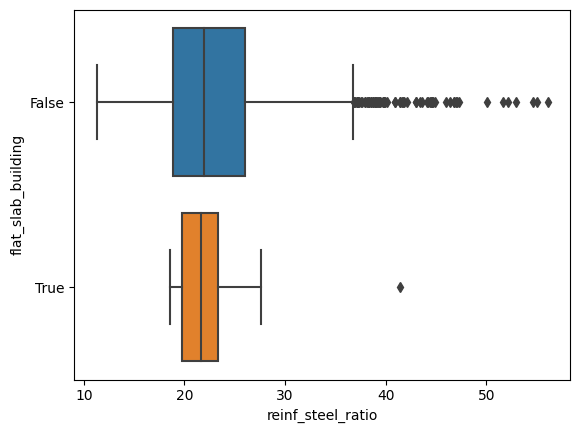

In [86]:
sns.boxplot(aux, x="reinf_steel_ratio", y="flat_slab_building")

<AxesSubplot: xlabel='reinf_steel_ratio', ylabel='Count'>

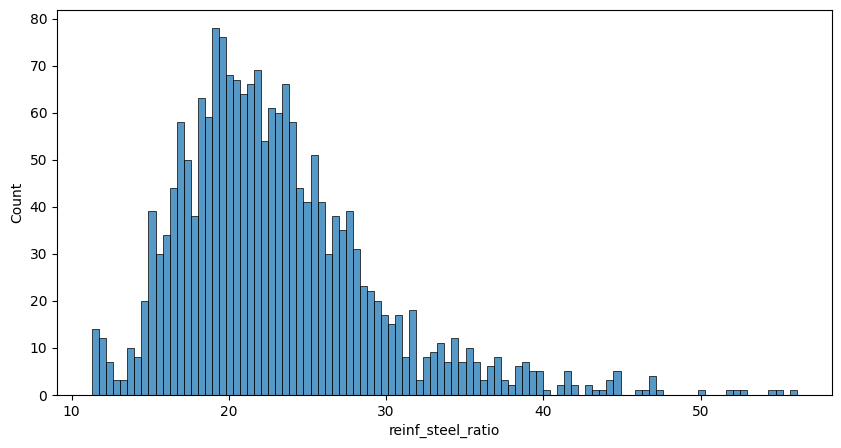

In [64]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ax=ax, data=aux, x="reinf_steel_ratio", bins=100)

In [87]:
min_, max_ = find_min_max_outliers_IQR(aux['reinf_steel_ratio'])
min_, max_

(8.055884086144848, 36.789708402152094)

In [89]:
aux[aux['reinf_steel_ratio'] > 36.7]['project_code'].tolist()

['BOLP17014M2_C01_I01_H11_Q02_R04_V06_S01_O01',
 'BOLP17014M2_C02_I02_H12_Q01_R03_V07_S02_O01',
 'BOLP17014M2_C05_I02_H03_Q02_R01_V10_S05_O01',
 'BOLP17014M2_C06_I03_H04_Q01_R02_V11_S06_O01',
 'BOLP17409_C01_I01_H03_Q03_R02_V08_S05_O01',
 'BOLP18010_C00_I00_H00_Q00_R00_V00_S00_O01',
 'BOLP18412_C01_I01_H03_Q03_R02_V08_S05_O01',
 'BOLP19016_C07_I02_H15_Q07_R08_V12_S03_O01',
 'BOLP19016_C11_I01_H06_Q07_R03_V12_S05_O01',
 'BOSC17009_C06_I02_H06_Q01_R05_V13_S03_O01',
 'BOSC17009_C09_I02_H05_Q04_R02_V13_S03_O01',
 'BOSC17214M1_C06_I02_H06_Q04_R03_V11_S06_O01',
 'BOSC17214M2_C05_I01_H05_Q02_R04_V10_S05_O01',
 'BOSC17214M2_C06_I02_H06_Q01_R03_V11_S06_O01',
 'BOSC17214M2_C10_I03_H10_Q01_R04_V04_S10_O01',
 'BOSC18012_C06_I02_H06_Q01_R05_V13_S03_O01',
 'BOSC18012_C09_I02_H05_Q04_R02_V13_S03_O01',
 'BOSC18012_C10_I03_H06_Q02_R03_V13_S03_O01',
 'BOSC18025_C06_I02_H06_Q01_R04_V13_S03_O01',
 'BOSC18025_C10_I03_H06_Q02_R04_V13_S03_O01',
 'BOSC19216_C02_I01_H02_Q06_R02_V13_S05_O01',
 'BOSC19216_C04_I0

In [91]:
df[df['project_code'] == 'BOLP18010_C00_I00_H00_Q00_R00_V00_S00_O01'][base_fields]

,project_code,floor_name,reinf_steel_ratio,concrete_m3_ratio,slab_type,slab_total_area,level,height
1262,BOLP18010_C00_I00_H00_Q00_R00_V00_S00_O01,SS,85.74,0.429281,FOAM_WAFFLE,621.793488,-2.26,3.06
1263,BOLP18010_C00_I00_H00_Q00_R00_V00_S00_O01,Z1,53.09,0.393310,FOAM_WAFFLE,571.864144,0.80,3.06
1264,BOLP18010_C00_I00_H00_Q00_R00_V00_S00_O01,Z2,71.74,0.490735,FOAM_WAFFLE,489.684393,5.30,4.50
1265,BOLP18010_C00_I00_H00_Q00_R00_V00_S00_O01,P3,36.80,0.414675,FOAM_WAFFLE,442.174738,9.80,4.50
1266,BOLP18010_C00_I00_H00_Q00_R00_V00_S00_O01,P4,30.43,0.220102,FOAM_WAFFLE,299.728257,13.04,3.24
1267,BOLP18010_C00_I00_H00_Q00_R00_V00_S00_O01,P5,30.49,0.222845,FOAM_WAFFLE,294.228401,16.28,3.24
1268,BOLP18010_C00_I00_H00_Q00_R00_V00_S00_O01,P6,29.36,0.222877,FOAM_WAFFLE,294.161377,19.52,3.24
1269,BOLP18010_C00_I00_H00_Q00_R00_V00_S00_O01,P7,29.51,0.221595,FOAM_WAFFLE,294.161210,22.76,3.24
1270,BOLP18010_C00_I00_H00_Q00_R00_V00_S00_O01,P8,29.49,0.221314,FOAM_WAFFLE,294.161210,26.00,3.24
1271,BOLP18010_C00_I00_H00_Q00_R00_V00_S00_O01,P9,29.46,0.221314,FOAM_WAFFLE,294.161210,29.24,3.24


In [92]:
def get_project_too_much_kg_m2(df):
    aux = df.groupby(by='project_code')[['total_reinf_steel', 'slab_total_area']].sum()
    aux['reinf_steel_ratio'] = aux['total_reinf_steel'] / aux['slab_total_area']
    aux.reset_index(inplace=True)
    return aux[aux['reinf_steel_ratio'] > 36.7]['project_code'].tolist()

In [687]:
project_codes = get_project_too_much_kg_m2(df)

In [688]:
len(project_codes)

0

In [113]:
ori_p = [p for p in project_codes if p[-31:] == 'C00_I00_H00_Q00_R00_V00_S00_O01']

Todos los edificios outliers que tiene muchos kg/m2 son versiones, excepto BOLP18010_C00_I00_H00_Q00_R00_V00_S00_O01 que tiene sótasnos con muchos kg y plantas muy subidas (2

In [114]:
ori_p

['BOLP18010_C00_I00_H00_Q00_R00_V00_S00_O01',
 'PYAS17020_C00_I00_H00_Q00_R00_V00_S00_O01',
 'PYAS18008_C00_I00_H00_Q00_R00_V00_S00_O01',
 'PYAS19004M1_C00_I00_H00_Q00_R00_V00_S00_O01',
 'PYAS20028_C00_I00_H00_Q00_R00_V00_S00_O01']

In [115]:
df[df['project_code'] == ori_p[4]][base_fields]

,project_code,floor_name,reinf_steel_ratio,concrete_m3_ratio,slab_type,slab_total_area,level,height
19183,PYAS20028_C00_I00_H00_Q00_R00_V00_S00_O01,Techo PB,63.32,0.133960,FOAM_WAFFLE,651.803447,1.24,3.06
19184,PYAS20028_C00_I00_H00_Q00_R00_V00_S00_O01,N1,60.80,0.137322,FOAM_WAFFLE,451.109258,4.30,3.06
19185,PYAS20028_C00_I00_H00_Q00_R00_V00_S00_O01,N2,46.05,0.132369,FOAM_WAFFLE,450.670480,7.36,3.06
19186,PYAS20028_C00_I00_H00_Q00_R00_V00_S00_O01,N3,41.44,0.130860,FOAM_WAFFLE,450.668820,10.42,3.06
19187,PYAS20028_C00_I00_H00_Q00_R00_V00_S00_O01,N4,39.48,0.127716,FOAM_WAFFLE,450.667160,13.48,3.06
19188,PYAS20028_C00_I00_H00_Q00_R00_V00_S00_O01,N5,37.04,0.127351,FOAM_WAFFLE,450.664660,16.54,3.06
19189,PYAS20028_C00_I00_H00_Q00_R00_V00_S00_O01,N6,35.32,0.126987,FOAM_WAFFLE,450.662160,19.60,3.06
19190,PYAS20028_C00_I00_H00_Q00_R00_V00_S00_O01,N7,33.76,0.126691,FOAM_WAFFLE,450.659660,22.66,3.06
19191,PYAS20028_C00_I00_H00_Q00_R00_V00_S00_O01,Azotea,34.24,0.126530,FOAM_WAFFLE,452.022707,25.72,3.06
19192,PYAS20028_C00_I00_H00_Q00_R00_V00_S00_O01,Deck+piscina,76.87,0.468478,FOAM_WAFFLE,100.314385,27.20,1.48


In [116]:
df = df.loc[~df['project_code'].isin(project_codes), :]

### Waffle slab

In [193]:
wdf = df[df['slab_type'] == 'FOAM_WAFFLE']
wdf[wf].describe()

,inter_axis_distance,waffle_slab_area,drop_panel_area,domes_area,domes_number
count,20138.000000,20138.000000,20138.000000,20138.000000,20138.000000
mean,0.818723,547.070522,120.877967,424.805030,637.949945
std,0.028142,476.273185,97.889579,392.861923,597.822540
min,0.665000,17.031837,6.280372,0.616225,1.000000
25%,0.785000,284.585495,65.329628,210.748950,307.000000
50%,0.820000,450.212579,98.433428,353.605600,517.000000
75%,0.820000,641.525242,136.027798,503.667600,762.000000
max,0.920000,7850.968484,1550.684771,6348.349950,10302.000000


#### waffle_slab_area

<AxesSubplot: xlabel='waffle_slab_area', ylabel='Count'>

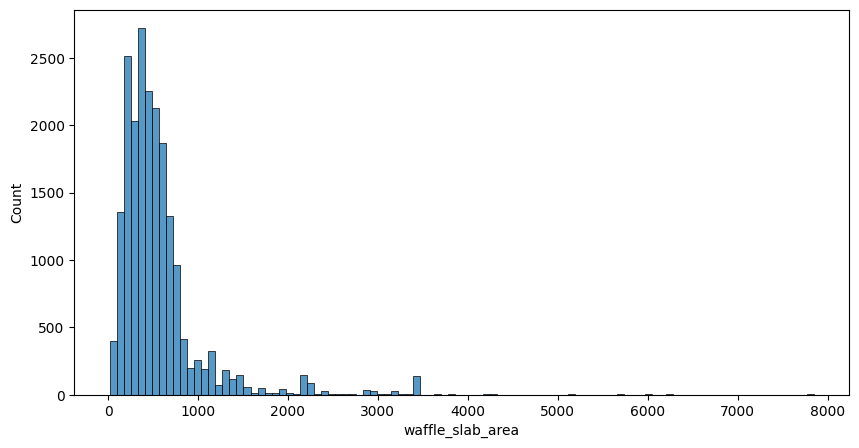

In [195]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ax=ax, data=wdf, x="waffle_slab_area", bins=100)

In [196]:
wdf[wdf['waffle_slab_area'] > 7000][base_fields+areas]

,project_code,floor_name,reinf_steel_ratio,concrete_m3_ratio,slab_type,slab_total_area,level,height,flat_slab_area,waffle_slab_area,drop_panel_area,domes_area,support_area,stair_area,slope_area,walls_area,retaining_walls_area
15208,PYAS16001_C00_I00_H00_Q00_R00_V00_S00_O01,Planta baja,19.76,0.161013,FOAM_WAFFLE,7850.968484,0.0,3.7,0.0,7850.968484,1550.684771,6348.34995,113.738856,48.792638,0.0,80.238856,73.258856


In [197]:
wdf[wdf['project_code'] == 'PYAS16001_C00_I00_H00_Q00_R00_V00_S00_O01'][base_fields+areas]

,project_code,floor_name,reinf_steel_ratio,concrete_m3_ratio,slab_type,slab_total_area,level,height,flat_slab_area,waffle_slab_area,drop_panel_area,domes_area,support_area,stair_area,slope_area,walls_area,retaining_walls_area
15208,PYAS16001_C00_I00_H00_Q00_R00_V00_S00_O01,Planta baja,19.76,0.161013,FOAM_WAFFLE,7850.968484,0.0,3.7,0.0,7850.968484,1550.684771,6348.349950,113.738856,48.792638,0.0,80.238856,73.258856
15209,PYAS16001_C00_I00_H00_Q00_R00_V00_S00_O01,Planta primera,17.78,0.110731,FOAM_WAFFLE,5971.467653,3.0,3.0,0.0,5971.467653,867.365305,5145.478750,36.402500,48.792638,0.0,6.980000,0.000000
15210,PYAS16001_C00_I00_H00_Q00_R00_V00_S00_O01,Planta Segunda,17.07,0.108519,FOAM_WAFFLE,5971.352508,6.0,3.0,0.0,5971.352508,852.088908,5157.187025,33.290000,48.792638,0.0,6.980000,0.000000
15211,PYAS16001_C00_I00_H00_Q00_R00_V00_S00_O01,Planta Tercera,16.35,0.107327,FOAM_WAFFLE,5971.332657,9.0,3.0,0.0,5971.332657,842.807807,5165.814175,31.690000,48.792638,0.0,6.980000,0.000000
15212,PYAS16001_C00_I00_H00_Q00_R00_V00_S00_O01,Planta Adicional1,16.17,0.106256,FOAM_WAFFLE,5971.141354,12.0,3.0,0.0,5971.141354,832.897962,5194.160525,30.055000,48.792757,0.0,6.980000,0.000000
15213,PYAS16001_C00_I00_H00_Q00_R00_V00_S00_O01,Planta Adicional2,16.14,0.105586,FOAM_WAFFLE,5971.118774,15.0,3.0,0.0,5971.118774,827.714194,5193.544300,29.260000,48.792638,0.0,6.980000,0.000000


In [200]:
df[(df['waffle_slab_area'] > 0) & (df['inter_axis_distance'] == 0)][base_fields+areas]

,project_code,floor_name,reinf_steel_ratio,concrete_m3_ratio,slab_type,slab_total_area,level,height,flat_slab_area,waffle_slab_area,drop_panel_area,domes_area,support_area,stair_area,slope_area,walls_area,retaining_walls_area
304,BOLP16011_C00_I00_H00_Q00_R00_V00_S00_O01,P1,27.03,0.404744,FLAT_SLAB,36.422982,1.02,2.7,0.0,36.422982,0.0,0.0,5.46,7.500998,0.0,0.0,0.0


- P1 en BOLP16011_C00_I00_H00_Q00_R00_V00_S00_O01 debe estar mal el area en waffle, 
debería estar en flat slab

In [689]:
wdf[wdf['project_code'] == 'BOLP16011_C00_I00_H00_Q00_R00_V00_S00_O01'][base_fields+wf]

,project_code,floor_name,reinf_steel_ratio,concrete_m3_ratio,slab_type,slab_total_area,level,height,inter_axis_distance,waffle_slab_area,drop_panel_area,domes_area,domes_number
302,BOLP16011_C00_I00_H00_Q00_R00_V00_S00_O01,Forjado 1,22.01,0.266715,FOAM_WAFFLE,837.078702,-4.56,2.70,0.82,837.078702,271.185082,596.4188,887
303,BOLP16011_C00_I00_H00_Q00_R00_V00_S00_O01,SEMISÓTANO,24.46,0.352635,FOAM_WAFFLE,514.065546,-1.68,2.88,0.82,514.065546,143.804872,359.0616,534
305,BOLP16011_C00_I00_H00_Q00_R00_V00_S00_O01,P2,19.99,0.128163,FOAM_WAFFLE,436.206382,3.72,2.70,0.82,436.206382,83.454894,353.6824,526
306,BOLP16011_C00_I00_H00_Q00_R00_V00_S00_O01,P3,19.03,0.127003,FOAM_WAFFLE,436.206382,6.42,2.70,0.82,436.206382,82.727635,353.6824,526
307,BOLP16011_C00_I00_H00_Q00_R00_V00_S00_O01,P4,17.97,0.124020,FOAM_WAFFLE,436.206257,9.12,2.70,0.82,436.206257,80.920451,357.0444,531
308,BOLP16011_C00_I00_H00_Q00_R00_V00_S00_O01,P5,17.12,0.122167,FOAM_WAFFLE,436.206257,11.82,2.70,0.82,436.206257,80.129407,355.6996,529
309,BOLP16011_C00_I00_H00_Q00_R00_V00_S00_O01,P6,16.26,0.121530,FOAM_WAFFLE,436.206257,14.52,2.70,0.82,436.206257,79.827800,354.3548,527
310,BOLP16011_C00_I00_H00_Q00_R00_V00_S00_O01,P7,15.63,0.121047,FOAM_WAFFLE,436.206257,17.22,2.70,0.82,436.206257,79.525851,354.3548,527
311,BOLP16011_C00_I00_H00_Q00_R00_V00_S00_O01,P8,15.11,0.120572,FOAM_WAFFLE,436.206257,19.92,2.70,0.82,436.206257,79.235004,354.3548,527
312,BOLP16011_C00_I00_H00_Q00_R00_V00_S00_O01,TERRAZA NATURADA,18.98,0.120410,FOAM_WAFFLE,436.206257,22.62,2.70,0.82,436.206257,78.950562,357.0444,531


In [202]:
df[(df['flat_slab_area'] > 0) & (df['inter_axis_distance'] != 0)][base_fields+areas]

,project_code,floor_name,reinf_steel_ratio,concrete_m3_ratio,slab_type,slab_total_area,level,height,flat_slab_area,waffle_slab_area,drop_panel_area,domes_area,support_area,stair_area,slope_area,walls_area,retaining_walls_area


#### inter_axis_distance

Hay 9 valores de interejes. La gran disparidad entre frecuencias de interejes se debe a que se han hecho versiones para dichos valores (0.785, 0.82, 0.86) y para el resto no.

Si esta característica es importante, podría ser un problema.

<AxesSubplot: xlabel='inter_axis_distance', ylabel='Count'>

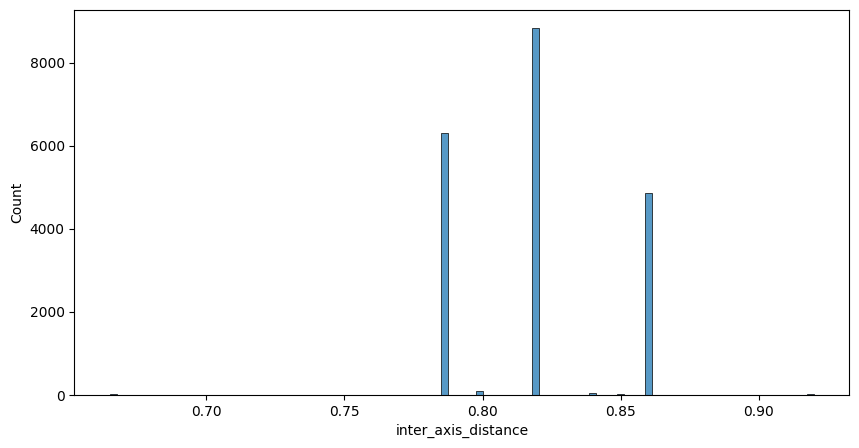

In [203]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ax=ax, data=wdf, x="inter_axis_distance", bins=100)

In [204]:
wdf.groupby(by='inter_axis_distance')['inter_axis_distance'].count()

inter_axis_distance
0.665       9
0.785    6291
0.800      83
0.820    6715
0.820    2119
0.840      30
0.850       9
0.860    4859
0.920      23
Name: inter_axis_distance, dtype: int64

In [205]:
wdf[wdf['inter_axis_distance'] == 0.92]['project_code'].unique()

array(['PYAS16003_C00_I00_H00_Q00_R00_V00_S00_O01',
       'PYAS17016_C00_I00_H00_Q00_R00_V00_S00_O01'], dtype=object)

#### drop_panel_area

<AxesSubplot: xlabel='drop_panel_area', ylabel='Count'>

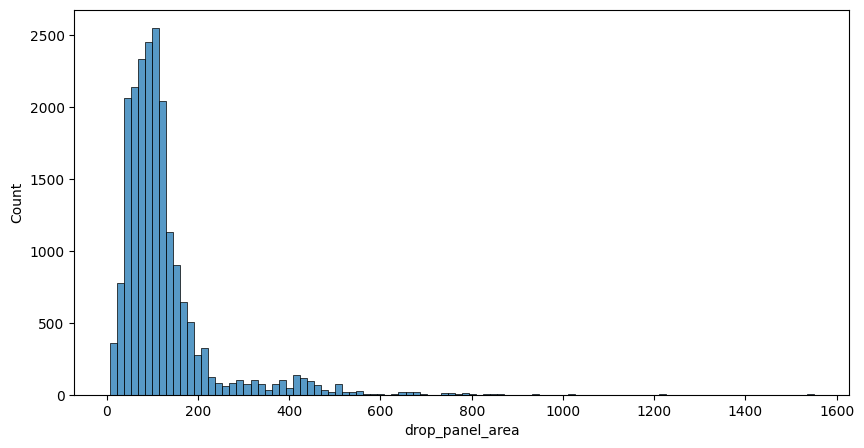

In [206]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ax=ax, data=wdf, x="drop_panel_area", bins=100)

In [207]:
df['drop_panel_area_ratio'] = df['drop_panel_area'] / df['slab_total_area']

<AxesSubplot: xlabel='drop_panel_area_ratio', ylabel='Count'>

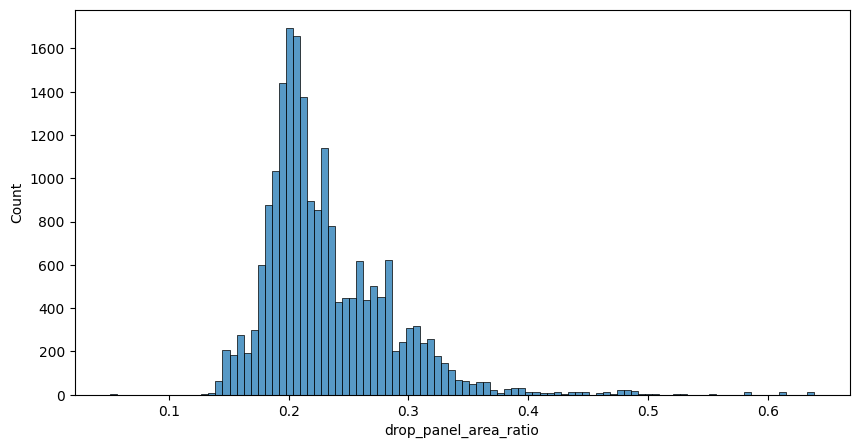

In [208]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ax=ax, data=wdf, x="drop_panel_area_ratio", bins=100)

In [209]:
find_min_max_outliers_IQR(wdf['drop_panel_area_ratio'])

(0.10478055104339182, 0.3513527046089332)

<AxesSubplot: >

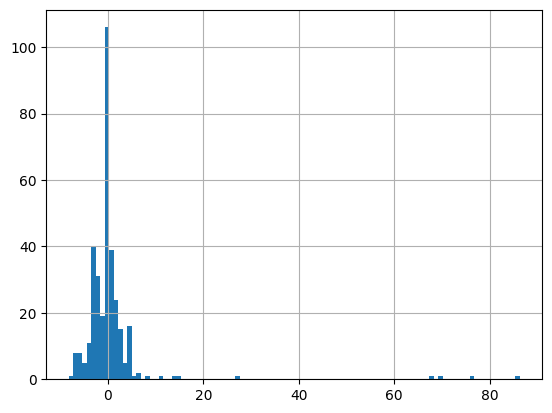

In [211]:
cond = (wdf['drop_panel_area_ratio'] > 0.35) & (wdf['slab_total_area'] > 200)
wdf[cond]['level'].hist(bins=100)

Cubieratas con un ratio de ábacos elevado?!?!

In [212]:
wdf[cond & (wdf['level'] > 8)][base_fields+['drop_panel_area_ratio']]

,project_code,floor_name,reinf_steel_ratio,concrete_m3_ratio,slab_type,slab_total_area,level,height,drop_panel_area_ratio
1194,BOLP18005_C00_I00_H00_Q00_R00_V00_S00_O01,Planta 3,35.26,0.280138,FOAM_WAFFLE,254.133911,11.10,3.15,0.351133
1195,BOLP18005_C00_I00_H00_Q00_R00_V00_S00_O01,Planta 4,35.67,0.279094,FOAM_WAFFLE,254.133840,14.25,3.15,0.350014
1199,BOLP18005_C00_I00_H00_Q00_R00_V00_S00_O01,Planta 8,30.66,0.276677,FOAM_WAFFLE,258.140010,26.85,3.15,0.354641
2504,BOLP19016_C02_I01_H01_Q05_R05_V12_S05_O01,CU,21.89,0.184914,FOAM_WAFFLE,208.404334,69.28,2.50,0.360093
2535,BOLP19016_C03_I03_H08_Q05_R05_V12_S05_O01,CU,21.68,0.188747,FOAM_WAFFLE,208.404334,67.78,2.50,0.360871
2628,BOLP19016_C06_I03_H07_Q06_R08_V12_S03_O01,CU,20.34,0.211577,FOAM_WAFFLE,208.404334,86.28,3.00,0.360093
2752,BOLP19016_C10_I03_H14_Q05_R09_V12_S05_O01,CU,20.80,0.258229,FOAM_WAFFLE,208.404334,76.78,2.75,0.360871
7724,BOSC15013_C00_I00_H00_Q00_R00_V00_S00_O01,CUBIERTA,25.33,0.198599,FOAM_WAFFLE,264.967176,15.00,3.00,0.398196


<AxesSubplot: xlabel='slab_total_area', ylabel='drop_panel_area'>

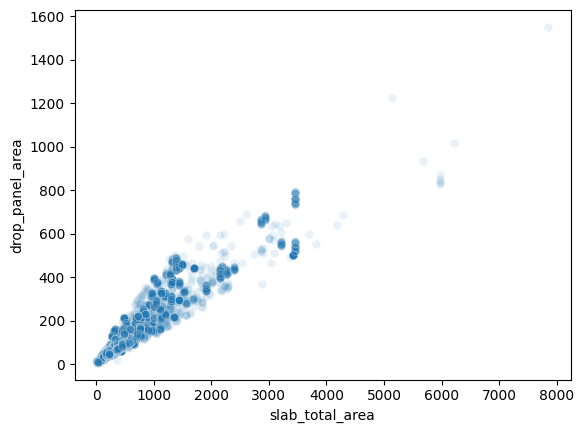

In [311]:
sns.scatterplot(data=wdf, x='slab_total_area', y='drop_panel_area', alpha=0.1)

In [178]:
ori_cond = df['project_code'].str.contains('_C00_I00_H00_Q00_R00_V00_S00_O01')

<AxesSubplot: xlabel='drop_panel_area_ratio', ylabel='reinf_steel_ratio'>

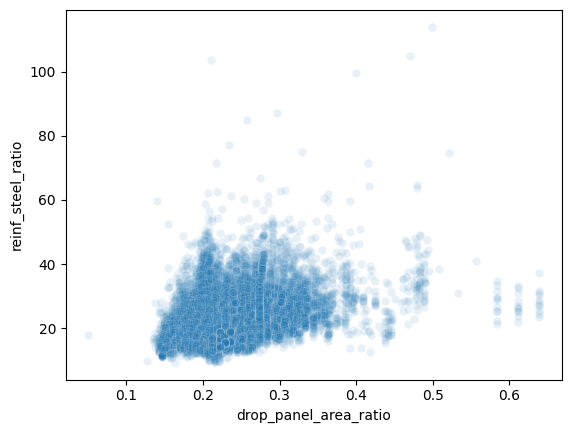

In [261]:
sns.scatterplot(data=wdf, x='drop_panel_area_ratio', y='reinf_steel_ratio', alpha=0.1)

<AxesSubplot: >

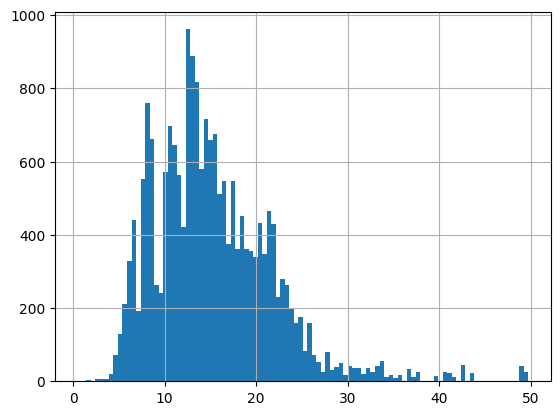

In [216]:
(wdf['drop_panel_area'] / wdf['support_area']).hist(bins=100)

#### domes_area

<AxesSubplot: xlabel='domes_area', ylabel='Count'>

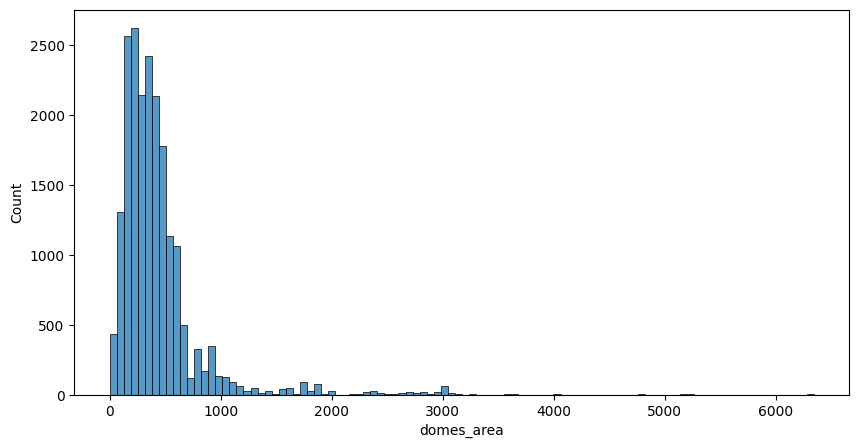

In [217]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ax=ax, data=wdf, x="domes_area", bins=100)

In [222]:
df["domes_area_m2"] = df["domes_area"] / df['slab_total_area']

<AxesSubplot: xlabel='domes_area_m2', ylabel='Count'>

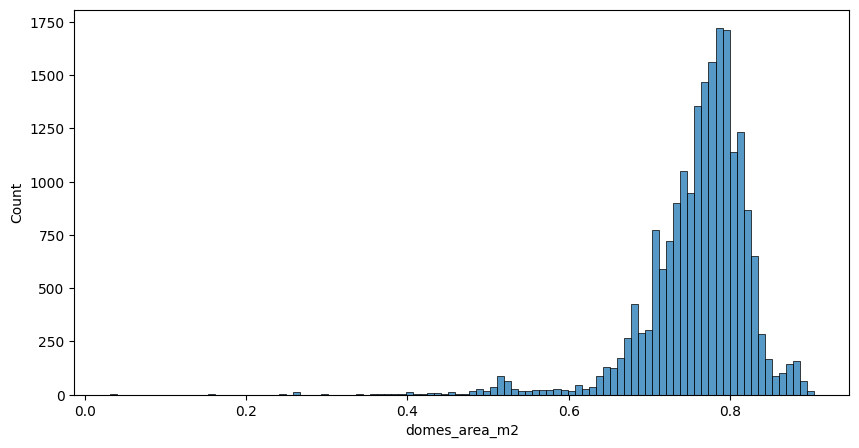

In [223]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ax=ax, data=wdf, x="domes_area_m2", bins=100)

In [224]:
find_min_max_outliers_IQR(wdf['domes_area_m2'])

(0.6402950128273139, 0.892261862024406)

In [239]:
wdf[wdf['domes_area_m2'] < 0.4][['project_code', 'drop_panel_area_ratio', 'domes_area_m2', 'drop_panel_area', 'domes_area', 'waffle_slab_area']]

,project_code,drop_panel_area_ratio,domes_area_m2,drop_panel_area,domes_area,waffle_slab_area
147,BOLP15001_C00_I00_H00_Q00_R00_V00_S00_O01,0.555745,0.355864,14.701008,9.413600,26.452780
809,BOLP17408_C09_I03_H04_Q01_R01_V12_S05_O01,0.386186,0.363547,36.925842,34.761200,95.616782
819,BOLP17408_C10_I01_H03_Q01_R01_V12_S05_O01,0.351934,0.393129,33.650785,37.589725,95.616782
829,BOLP17408_C11_I02_H02_Q02_R02_V12_S05_O01,0.368010,0.344580,35.187902,32.947600,95.616782
2853,BOLP19023_C01_I01_H12_Q05_R05_V01_S05_O01,0.584061,0.030861,11.662264,0.616225,19.967542
2867,BOLP19023_C03_I03_H00_Q07_R07_V03_S09_O01,0.638909,0.296321,12.757452,5.916800,19.967542
2888,BOLP19023_C06_I03_H08_Q05_R04_V06_S06_O01,0.638909,0.259281,12.757452,5.177200,19.967542
2909,BOLP19023_C09_I03_H04_Q01_R01_V09_S02_O01,0.638909,0.259281,12.757452,5.177200,19.967542
4900,BOLP20324_C06_I03_H03_Q05_R05_V12_S05_O01,0.260140,0.374515,34.419967,49.553200,132.313045
4924,BOLP20324_C09_I03_H03_Q04_R05_V12_S05_O01,0.260140,0.374515,34.419967,49.553200,132.313045


In [267]:
w_ori_cond = wdf['project_code'].str.contains('_C00_I00_H00_Q00_R00_V00_S00_O01')

NO TIENE SENTIDO QUE HAYA VALORES NEGATIVOS EN st_beam_area!!

<AxesSubplot: >

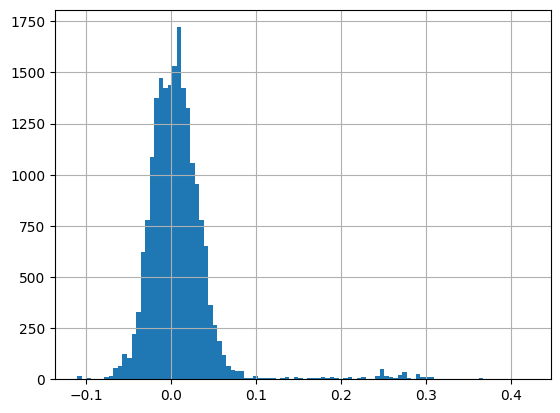

In [260]:
st_beam_area = (wdf['waffle_slab_area'] - (wdf['drop_panel_area'] + wdf['domes_area']))
st_beam_area_m2 = (st_beam_area / wdf['waffle_slab_area'])
st_beam_area_m2.hist(bins=100)

In [268]:
wdf['st_beam_area'] = st_beam_area

/tmp/ipykernel_145452/3945009050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wdf['st_beam_area'] = st_beam_area


<AxesSubplot: >

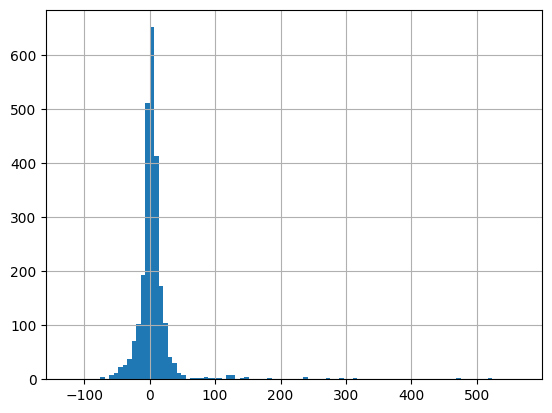

In [269]:
wdf[w_ori_cond]['st_beam_area'].hist(bins=100)

In [266]:
wdf[(st_beam_area < 0)][['st_beam_area', 'waffle_slab_area', 'drop_panel_area', 'domes_area']]

,st_beam_area,waffle_slab_area,drop_panel_area,domes_area
0,-92.087947,3292.093703,648.858450,2735.323200
1,-3.518795,881.073190,257.242785,627.349200
2,-8.934574,215.658464,40.355438,184.237600
3,-12.027079,230.876940,46.563219,196.340800
4,-12.249934,803.681221,166.392755,649.538400
...,...,...,...,...
22617,-1.276119,762.175038,137.982782,625.468375
22620,-6.791454,787.338046,137.233650,656.895850
22627,-3.899096,591.867685,104.019231,491.747550
22628,-14.203027,624.035644,107.668946,530.569725


In [246]:
find_min_max_outliers_IQR(st_beam_area_m2)

(-0.06952590914236774, 0.07686934744291762)

In [253]:
wdf[st_beam_area_m2 > 0.08][base_fields]

,project_code,floor_name,reinf_steel_ratio,concrete_m3_ratio,slab_type,slab_total_area,level,height
65,BOLP14009_C00_I00_H00_Q00_R00_V00_S00_O01,P26,23.15,0.210473,FOAM_WAFFLE,236.804422,79.10,2.90
67,BOLP14009_C00_I00_H00_Q00_R00_V00_S00_O01,CUBIERTA,18.76,0.189221,FOAM_WAFFLE,172.229654,84.90,2.90
147,BOLP15001_C00_I00_H00_Q00_R00_V00_S00_O01,CUBIERTA,40.98,0.574601,FOAM_WAFFLE,26.452780,60.30,3.06
520,BOLP17014M1_C10_I01_H08_Q02_R06_V04_S10_O01,PLANTA 02,38.20,0.148548,FOAM_WAFFLE,118.127502,4.25,4.25
521,BOLP17014M1_C10_I01_H08_Q02_R06_V04_S10_O01,PLANTA 03,22.43,0.129244,FOAM_WAFFLE,118.127331,6.75,2.50
...,...,...,...,...,...,...,...,...
20150,PYAS20201_C11_I03_H04_Q07_R01_V07_S00_O01,Planta 1,17.04,0.127071,FOAM_WAFFLE,446.460217,3.50,3.25
20151,PYAS20201_C11_I03_H04_Q07_R01_V07_S00_O01,Planta 2,16.45,0.127004,FOAM_WAFFLE,455.136523,6.75,3.25
20152,PYAS20201_C11_I03_H04_Q07_R01_V07_S00_O01,Planta 3,16.27,0.127004,FOAM_WAFFLE,455.136523,10.00,3.25
20153,PYAS20201_C11_I03_H04_Q07_R01_V07_S00_O01,TERRAZA,13.26,0.127004,FOAM_WAFFLE,455.136523,13.25,3.25


In [254]:
wdf['st_beam_area_m2'] = st_beam_area_m2

/tmp/ipykernel_145452/18712985.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wdf['st_beam_area_m2'] = st_beam_area_m2


<AxesSubplot: xlabel='st_beam_area_m2', ylabel='slab_total_area'>

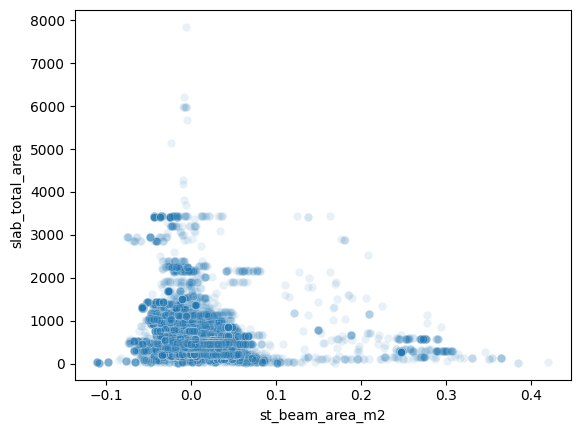

In [690]:
sns.scatterplot(data=wdf, x='st_beam_area_m2', y='slab_total_area', alpha=0.1)

In [279]:
wdf[(wdf['st_beam_area_m2'] > 0.2) & (wdf['slab_total_area'] > 800)][['project_code', 'floor_name', 'st_beam_area_m2']+wf]

,project_code,floor_name,st_beam_area_m2,inter_axis_distance,waffle_slab_area,drop_panel_area,domes_area,domes_number
8484,BOSC17026M1_C00_I00_H00_Q00_R00_V00_S00_O01,Cubierta,0.224754,0.840,1330.654198,253.308103,778.2768,1103
8485,BOSC17026M2_C00_I00_H00_Q00_R00_V00_S00_O01,SUBSUELO 1,0.209357,0.840,1147.286075,198.671754,708.4224,1004
8486,BOSC17026M2_C00_I00_H00_Q00_R00_V00_S00_O01,PB,0.209357,0.840,1147.286075,198.671754,708.4224,1004
8487,BOSC17026M2_C00_I00_H00_Q00_R00_V00_S00_O01,P1,0.209357,0.840,1147.286075,198.671754,708.4224,1004
8488,BOSC17026M2_C00_I00_H00_Q00_R00_V00_S00_O01,P2,0.209357,0.840,1147.286075,198.671754,708.4224,1004
8489,BOSC17026M2_C00_I00_H00_Q00_R00_V00_S00_O01,TECHOS,0.277424,0.840,934.620190,177.886426,497.4480,705
9761,BOSC18027M2_C00_I00_H00_Q00_R00_V00_S00_O01,P2,0.206481,0.840,1526.956520,302.150167,909.5184,1289
18602,PYAS20008M1_C00_I00_H00_Q00_R00_V00_S00_O02,P1,0.277657,0.800,1125.736080,209.647866,603.5200,943
18746,PYAS20008M2_C00_I00_H00_Q00_R00_V00_S00_O02,P1,0.294929,0.800,845.239607,167.794109,428.1600,669
19174,PYAS20025_C00_I00_H00_Q00_R00_V00_S00_O01,N8,0.208763,0.785,2536.163428,463.678777,1543.0274,2504


<AxesSubplot: xlabel='slab_total_area', ylabel='domes_area'>

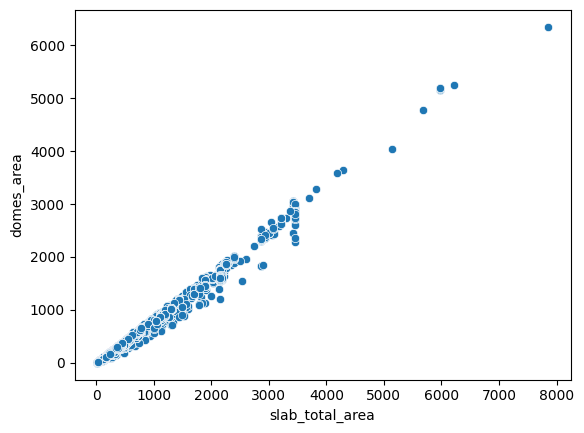

In [691]:
sns.scatterplot(data=wdf, x='slab_total_area', y='domes_area')

<AxesSubplot: xlabel='domes_number', ylabel='Count'>

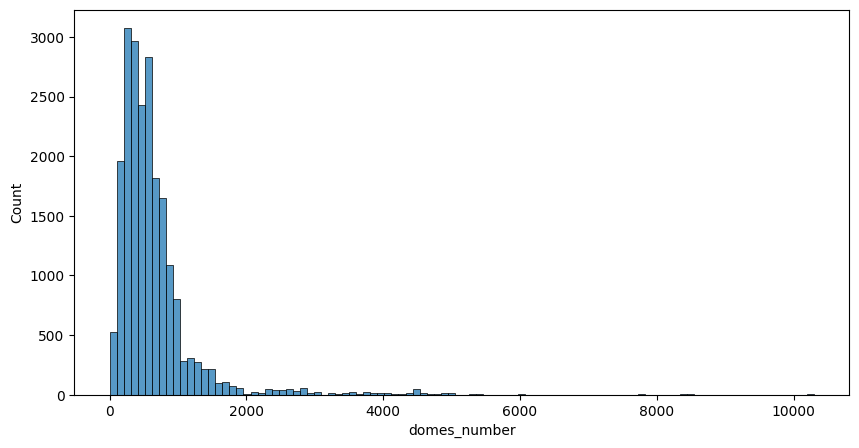

In [418]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ax=ax, data=wdf, x="domes_number", bins=100)

In [430]:
df["domes_number_m2"] = df["domes_number"] / df['slab_total_area']

/tmp/ipykernel_61396/3248360506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["domes_number_m2"] = df["domes_number"] / df['slab_total_area']


<AxesSubplot: xlabel='domes_number_m2', ylabel='Count'>

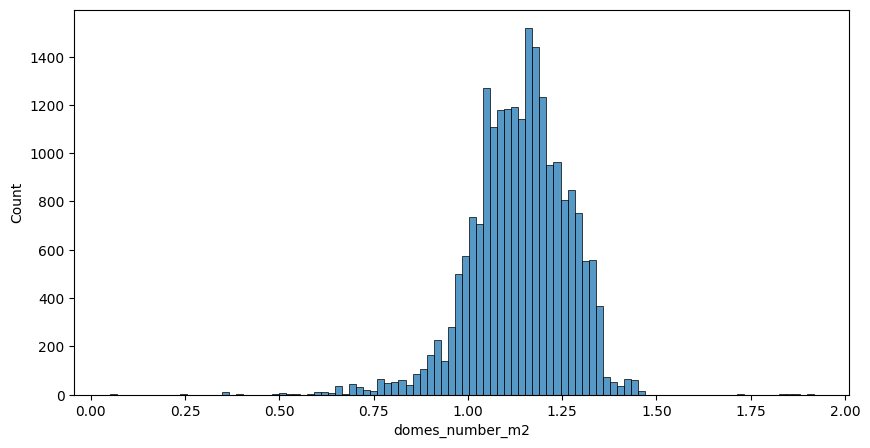

In [431]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ax=ax, data=df[df['slab_type'] == 'FOAM_WAFFLE'], x="domes_number_m2", bins=100)

### depth

Todos los forjados tipo losa son de 20 cm y los reticulares tienen differentes cantos.

In [280]:
df.groupby(by='depth')['depth'].count()

depth
0.20    1216
0.25    1728
0.26    1601
0.27    2180
0.28    1715
0.29    1607
0.30    2827
0.31    1478
0.32    2090
0.33    1564
0.34    1584
0.35    1755
0.40       9
Name: depth, dtype: int64

<AxesSubplot: xlabel='depth', ylabel='Count'>

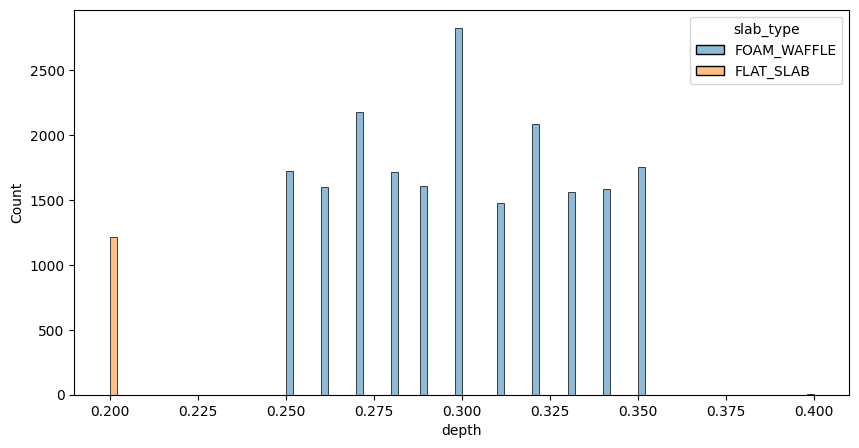

In [281]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ax=ax, data=df, x="depth", hue='slab_type', bins=100)

 # Alturas
 ## height
 
 El rango va de 0.5 metros a 7 metros. Es normal que haya alturas tan bajas porque corresponden a plantas que tienen dobles alturas y se modela como dos plantas. 3 metros es lo más común y 7 metros parece mucho.
 
Hay un edificio original (BOSC18003M2_C00_I00_H00_Q00_R00_V00_S00_O01) que tiene varios de 6 metros y uno de 7.

In [523]:
df[['height']].describe()

,height
count,22619.000000
mean,3.058226
std,0.496186
min,0.500000
25%,2.750000
50%,3.000000
75%,3.250000
max,7.000000


<AxesSubplot: xlabel='height', ylabel='Count'>

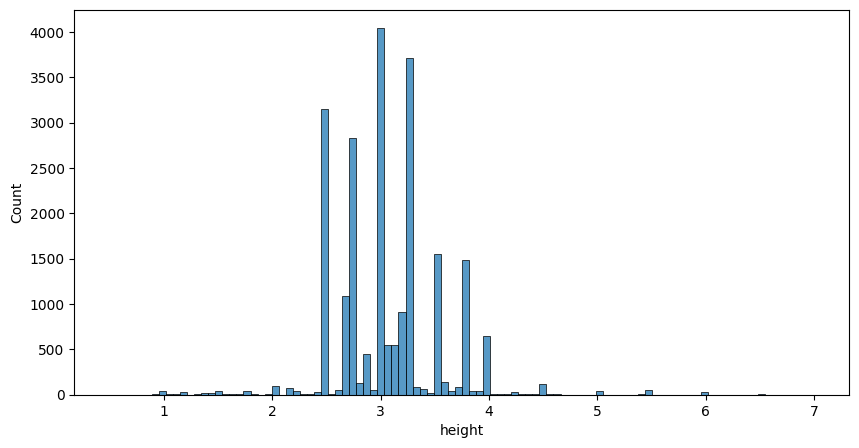

In [521]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ax=ax, data=df, x="height", bins=100)

In [526]:
df[df['height'] > 5][base_fields]

,project_code,floor_name,reinf_steel_ratio,concrete_m3_ratio,slab_type,slab_total_area,level,height
272,BOLP16008_C00_I00_H00_Q00_R00_V00_S00_O01,PLANTA +10.00,15.86,0.118725,FOAM_WAFFLE,2150.486669,10.00,5.20
475,BOLP17014M1_C01_I01_H11_Q02_R06_V06_S01_O01,PLANTA 02,62.28,0.148063,FOAM_WAFFLE,118.127502,5.50,5.50
534,BOLP17014M2_C01_I01_H11_Q02_R04_V06_S01_O01,PLANTA 02,85.10,0.256729,FOAM_WAFFLE,33.974458,5.50,5.50
538,BOLP17014M2_C02_I02_H12_Q01_R03_V07_S02_O01,PLANTA 02,106.50,0.290782,FOAM_WAFFLE,33.992111,6.00,6.00
720,BOLP17408_C01_I01_H12_Q05_R05_V12_S05_O01,Piso 1,25.86,0.201426,FOAM_WAFFLE,284.586245,6.00,6.00
...,...,...,...,...,...,...,...,...
19603,PYAS20033_C09_I03_H11_Q05_R07_V03_S00_O01,P01,22.89,0.279819,FLAT_SLAB,2263.635489,10.82,5.50
19604,PYAS20033_C09_I03_H11_Q05_R07_V03_S00_O01,P02,17.05,0.254727,FLAT_SLAB,3206.161069,16.32,5.50
19605,PYAS20033_C09_I03_H11_Q05_R07_V03_S00_O01,P03,19.00,0.269656,FLAT_SLAB,2255.058603,21.82,5.50
22601,PYAS21002_C00_I00_H00_Q00_R00_V00_S00_O01,PLANTA 2,18.04,0.116476,FOAM_WAFFLE,3368.317866,6.65,6.65


In [531]:
aux = df[df['height'] > 5].groupby(by='project_code')['project_code'].count()
aux[aux == 5]

project_code
BOLP20333_C05_I03_H05_Q06_R08_V12_S05_O01      5
BOLP20333_C10_I01_H11_Q05_R06_V12_S03_O01      5
BOSC18003M2_C00_I00_H00_Q00_R00_V00_S00_O01    5
PYAS18415_C05_I01_H11_Q06_R08_V07_S00_O01      5
PYAS18415_C07_I02_H11_Q02_R05_V07_S00_O01      5
PYAS20033_C09_I03_H11_Q05_R07_V03_S00_O01      5
Name: project_code, dtype: int64

In [532]:
df[df['project_code'] == 'BOSC18003M2_C00_I00_H00_Q00_R00_V00_S00_O01'][base_fields+['foundation_height', 'total_height']]

,project_code,floor_name,reinf_steel_ratio,concrete_m3_ratio,slab_type,slab_total_area,level,height,foundation_height,total_height
8714,BOSC18003M2_C00_I00_H00_Q00_R00_V00_S00_O01,SUBSUELO 1,24.50,0.183329,FOAM_WAFFLE,2141.704742,-2.50,3.30,-5.8,82.15
8715,BOSC18003M2_C00_I00_H00_Q00_R00_V00_S00_O01,PLANTA BAJA,28.12,0.213985,FOAM_WAFFLE,1989.953436,1.65,4.15,-5.8,82.15
8716,BOSC18003M2_C00_I00_H00_Q00_R00_V00_S00_O01,PISO 1,29.88,0.223897,FOAM_WAFFLE,1919.544400,7.65,6.00,-5.8,82.15
8717,BOSC18003M2_C00_I00_H00_Q00_R00_V00_S00_O01,PISO 2,36.60,0.217071,FOAM_WAFFLE,1919.516900,13.65,6.00,-5.8,82.15
8718,BOSC18003M2_C00_I00_H00_Q00_R00_V00_S00_O01,PISO 3,39.98,0.232392,FOAM_WAFFLE,1532.577223,19.65,6.00,-5.8,82.15
8719,BOSC18003M2_C00_I00_H00_Q00_R00_V00_S00_O01,PISO 4,30.30,0.226691,FOAM_WAFFLE,1532.548342,25.65,6.00,-5.8,82.15
8720,BOSC18003M2_C00_I00_H00_Q00_R00_V00_S00_O01,PISO 5,23.18,0.166683,FOAM_WAFFLE,1919.433812,30.15,4.50,-5.8,82.15
8721,BOSC18003M2_C00_I00_H00_Q00_R00_V00_S00_O01,PISO 6. CONVENCIONES,25.42,0.163818,FOAM_WAFFLE,1919.421312,34.65,4.50,-5.8,82.15
8722,BOSC18003M2_C00_I00_H00_Q00_R00_V00_S00_O01,PISO 7,25.50,0.197120,FOAM_WAFFLE,1919.408812,41.65,7.00,-5.8,82.15
8723,BOSC18003M2_C00_I00_H00_Q00_R00_V00_S00_O01,PISO 8,23.55,0.177835,FOAM_WAFFLE,834.237995,46.15,4.50,-5.8,82.15


## foundation_height

No parece que haya valores mal.

In [535]:
df[['foundation_height']].describe()

,foundation_height
count,22619.000000
mean,-3.203329
std,2.515461
min,-13.280000
25%,-4.550000
50%,-2.900000
75%,-1.470000
max,1.000000


<AxesSubplot: xlabel='foundation_height', ylabel='Count'>

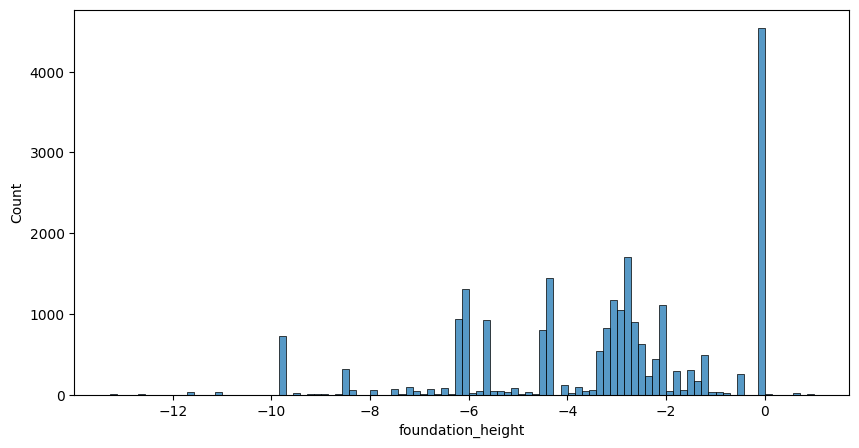

In [536]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ax=ax, data=df, x="foundation_height", bins=100)

## total_height 

NO casa para 126 proyectos la altura total, con la suma de las alturas de plantas teniendo en cuenta la cota de cimentación. Aunque, posteriormente se ha analizado y no tiene por qué, si una planta pilla a mitad de la cota cero.

Analizando 3 proyectos originales, la cota del último level corresponde con la altura total. Pero no ciencide el level de la primera planta, si se suma su altura al del inicio de la cimentación. En algunos casos parece que faltan plantas o que el foundation_height está mal!


<AxesSubplot: xlabel='total_height', ylabel='Count'>

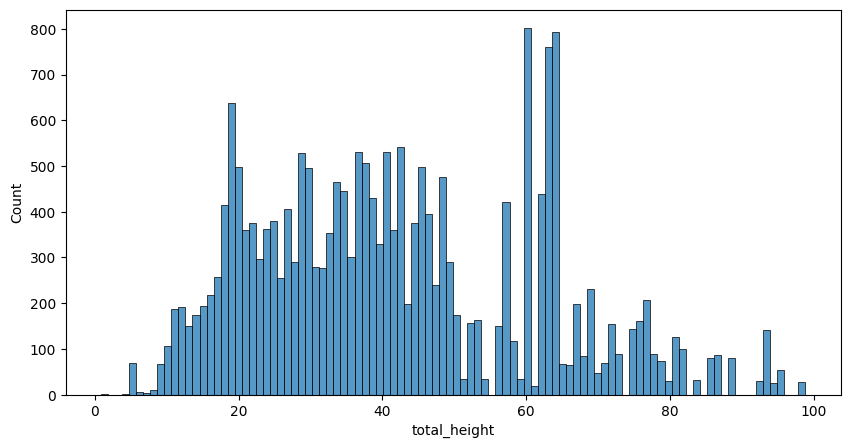

In [282]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ax=ax, data=df, x="total_height", bins=100)

In [590]:
aux = df[['project_code', 'height', 'foundation_height', 'total_height']].groupby(by='project_code').agg(
    {'height': 'sum', 'foundation_height': 'last', 'total_height': 'last'}
)
aux

,height,foundation_height,total_height
project_code,,,
BOCB19002_C00_I00_H00_Q00_R00_V00_S00_O01,13.00,0.00,13.00
BOCB19004_C00_I00_H00_Q00_R00_V00_S00_O01,63.25,-4.80,58.45
BOCB19005_C00_I00_H00_Q00_R00_V00_S00_O01,42.90,-5.10,37.80
BOLP14009_C00_I00_H00_Q00_R00_V00_S00_O01,96.90,-11.60,86.90
BOLP14013_C00_I00_H00_Q00_R00_V00_S00_O01,84.30,-7.52,76.78
...,...,...,...
PYAS20601M5_C11_I03_H13_Q01_R01_V07_S00_O01,40.50,-2.75,37.75
PYAS21002_C00_I00_H00_Q00_R00_V00_S00_O01,9.65,-3.00,6.65
PYAS21003_C00_I00_H00_Q00_R00_V00_S00_O01,48.75,-9.75,39.00


<AxesSubplot: >

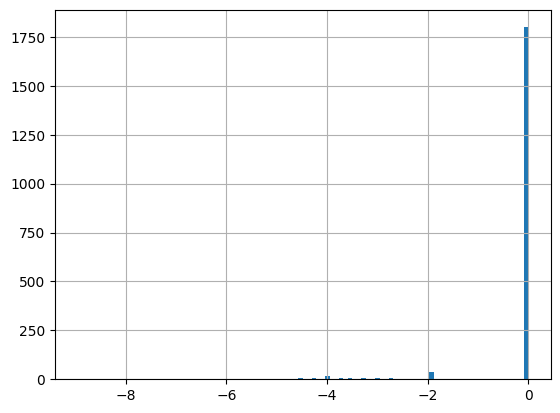

In [598]:
(aux['height'] + aux['foundation_height'] - aux['total_height']).hist(bins=100)

In [586]:
errors = (aux['height'] + aux['foundation_height'] - aux['total_height']).abs() > 0.5

In [587]:
errors.sum()

126

In [588]:
df.groupby(by='project_code')['project_code'].last()[errors].unique()

array(['BOLP14009_C00_I00_H00_Q00_R00_V00_S00_O01',
       'BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01',
       'BOLP17014M1_C00_I00_H00_Q00_R00_V00_S00_O01',
       'BOLP18412_C01_I01_H03_Q03_R02_V08_S05_O01',
       'BOLP18412_C02_I02_H04_Q02_R01_V12_S05_O01',
       'BOLP18412_C03_I03_H05_Q01_R01_V12_S05_O01',
       'BOLP18412_C04_I01_H06_Q05_R02_V12_S05_O01',
       'BOLP18412_C05_I02_H07_Q06_R03_V12_S05_O01',
       'BOLP18412_C06_I03_H13_Q05_R05_V12_S05_O01',
       'BOLP18412_C07_I01_H14_Q05_R01_V12_S05_O01',
       'BOLP18412_C08_I02_H15_Q03_R09_V12_S05_O01',
       'BOLP18412_C09_I03_H04_Q04_R02_V12_S05_O01',
       'BOLP18412_C10_I01_H03_Q02_R03_V04_S05_O01',
       'BOLP18412_C11_I02_H09_Q07_R03_V12_S05_O01',
       'BOLP19014_C00_I00_H00_Q00_R00_V00_S00_O01',
       'BOLP19017M1_C00_I00_H00_Q00_R00_V00_S00_O01',
       'BOLP19018_C00_I00_H00_Q00_R00_V00_S00_O01',
       'BOLP20302_C01_I02_H00_Q00_R04_V12_S05_O02',
       'BOLP20302_C02_I02_H00_Q00_R04_V12_S05_O02',
       '

In [597]:
df[df['project_code'] == 'BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01'][['project_code', 'floor_name', 'level', 'height', 'foundation_height', 'total_height']]

,project_code,floor_name,level,height,foundation_height,total_height
182,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,SEMI SOTANO,-2.70,1.56,-6.66,33.96
183,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,PRIMER PISO +0.95,-1.80,0.90,-6.66,33.96
184,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,SEGUNDO PISO,2.16,3.96,-6.66,33.96
185,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,TERCER PISO,5.76,3.60,-6.66,33.96
186,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,CUARTO PISO,10.08,4.32,-6.66,33.96
187,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,QUINTO PISO,13.68,3.60,-6.66,33.96
188,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,SEXTO PISO,17.28,3.60,-6.66,33.96
189,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,SEPTIMO PISO,21.24,3.96,-6.66,33.96
190,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,OCTAVO PISO,24.48,3.24,-6.66,33.96
191,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,NOVENO PISO,27.72,3.24,-6.66,33.96


In [599]:
df[df['project_code'] == 'BOLP14009_C00_I00_H00_Q00_R00_V00_S00_O01'][['project_code', 'floor_name', 'level', 'height', 'foundation_height', 'total_height']]

,project_code,floor_name,level,height,foundation_height,total_height
36,BOLP14009_C00_I00_H00_Q00_R00_V00_S00_O01,ST3,-7.1,2.9,-11.6,86.9
37,BOLP14009_C00_I00_H00_Q00_R00_V00_S00_O01,ST2,-4.2,2.9,-11.6,86.9
38,BOLP14009_C00_I00_H00_Q00_R00_V00_S00_O01,ST1,-1.3,2.9,-11.6,86.9
39,BOLP14009_C00_I00_H00_Q00_R00_V00_S00_O01,PB (COMERCIAL),1.6,2.9,-11.6,86.9
40,BOLP14009_C00_I00_H00_Q00_R00_V00_S00_O01,P01 (COMERCIAL),5.0,3.4,-11.6,86.9
41,BOLP14009_C00_I00_H00_Q00_R00_V00_S00_O01,P02 (COMERCIAL),8.4,3.4,-11.6,86.9
42,BOLP14009_C00_I00_H00_Q00_R00_V00_S00_O01,P03 (OFICINA),12.1,3.7,-11.6,86.9
43,BOLP14009_C00_I00_H00_Q00_R00_V00_S00_O01,P04 (OFICINA),15.0,2.9,-11.6,86.9
44,BOLP14009_C00_I00_H00_Q00_R00_V00_S00_O01,P05 (OFICINA),17.9,2.9,-11.6,86.9
45,BOLP14009_C00_I00_H00_Q00_R00_V00_S00_O01,P06 (OFICINA),20.8,2.9,-11.6,86.9


In [600]:
df[df['project_code'] == 'BOLP17014M1_C00_I00_H00_Q00_R00_V00_S00_O01'][['project_code', 'floor_name', 'level', 'height', 'foundation_height', 'total_height']]

,project_code,floor_name,level,height,foundation_height,total_height
470,BOLP17014M1_C00_I00_H00_Q00_R00_V00_S00_O01,PLANTA 02,3.8,3.8,-1.0,18.2
471,BOLP17014M1_C00_I00_H00_Q00_R00_V00_S00_O01,PLANTA 03,7.4,3.6,-1.0,18.2
472,BOLP17014M1_C00_I00_H00_Q00_R00_V00_S00_O01,PLANTA 04,11.0,3.6,-1.0,18.2
473,BOLP17014M1_C00_I00_H00_Q00_R00_V00_S00_O01,PLANTA 05,14.6,3.6,-1.0,18.2
474,BOLP17014M1_C00_I00_H00_Q00_R00_V00_S00_O01,CUBIERTA,18.2,3.6,-1.0,18.2


## level 

Como es normal los level entre 0 y 20 son los más frecuentes.

<div class="alert alert-block alert-warning">
<b>OJO:</b> HAY 433 edificios donde falta alguna planta inicial!!
</div>

<AxesSubplot: xlabel='level', ylabel='Count'>

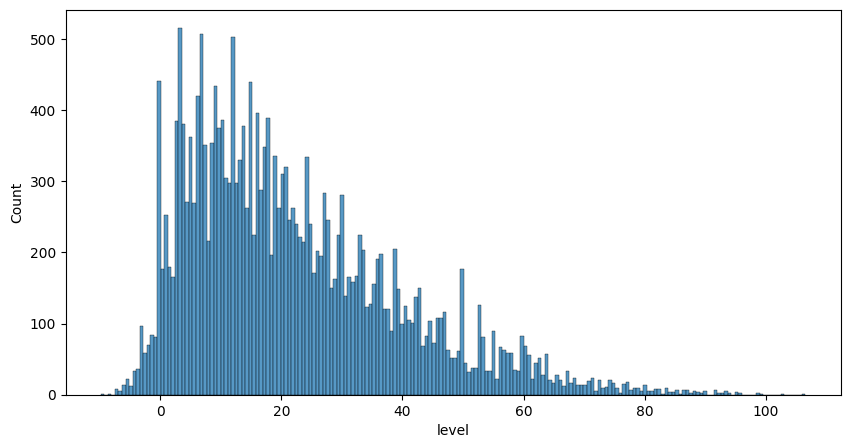

In [602]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ax=ax, data=df, x="level", bins=200)

In [287]:
aux = df[['project_code', 'height', 'foundation_height', 'level']].groupby(by='project_code').agg(
    {'height': 'first', 'foundation_height': 'first', 'level': 'first'}
)

error_initial_level_cond = aux['height'] + aux['foundation_height'] != aux['level']
error_initial_level_cond.sum()

433

<AxesSubplot: >

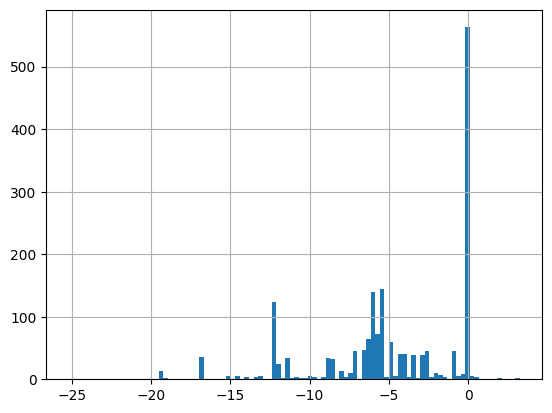

In [294]:
(aux['level'] - aux['height'] + aux['foundation_height']).hist(bins=100)

In [289]:
aux[error_initial_level_cond]

,height,foundation_height,level
project_code,,,
BOCB19005_C00_I00_H00_Q00_R00_V00_S00_O01,3.00,-5.10,-2.10
BOLP14009_C00_I00_H00_Q00_R00_V00_S00_O01,2.90,-11.60,-7.10
BOLP14013_C00_I00_H00_Q00_R00_V00_S00_O01,2.70,-7.52,-4.82
BOLP15009_C00_I00_H00_Q00_R00_V00_S00_O01,2.88,-2.48,0.40
BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,1.56,-6.66,-2.70
...,...,...,...
PYAS20409_C07_I02_H14_Q02_R04_V07_S00_O01,4.00,-3.33,0.67
PYAS20409_C08_I01_H15_Q03_R09_V07_S00_O01,4.00,-3.33,0.67
PYAS20409_C09_I03_H04_Q04_R04_V07_S00_O01,3.25,-3.33,-0.08


## min max hights

No les encuentro sentido!

In [620]:
base_hf = ['total_height', 'foundation_height', 'level', 'height']

min_max = [
    'floor_max_height',
'floor_min_height',
'max_height_all_floors',
'min_height_all_floors',
          ]

'double_height'

In [625]:
aux = df.groupby(by='project_code')[['floor_max_height', 'max_height_all_floors']].agg({'floor_max_height': 'max', 'max_height_all_floors': 'last'})

In [626]:
aux[aux['floor_max_height'] - aux['max_height_all_floors'] != 0]

,floor_max_height,max_height_all_floors
project_code,,
BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,4.32,4.50
BOLP16009_C00_I00_H00_Q00_R00_V00_S00_O01,3.20,3.06
BOLP16028M1_C00_I00_H00_Q00_R00_V00_S00_O01,3.90,3.80
BOLP17012_C00_I00_H00_Q00_R00_V00_S00_O01,5.74,4.74
BOLP19009_C00_I00_H00_Q00_R00_V00_S00_O02,4.15,3.00
BOLP19016_C00_I00_H00_Q00_R00_V00_S00_O01,4.80,4.83
BOLP20005M1_C00_I00_H00_Q00_R00_V00_S00_O02,4.95,4.00
BOLP20005M2_C00_I00_H00_Q00_R00_V00_S00_O02,4.95,4.00
BOSC13013_C00_I00_H00_Q00_R00_V00_S00_O01,3.40,6.40


In [617]:
cond = df.groupby(by='project_code')['floor_max_height'].max() != df.groupby(by='project_code')['max_height_all_floors'].last()
(cond).sum()

25

In [622]:
cond[cond]

project_code
BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01      True
BOLP16009_C00_I00_H00_Q00_R00_V00_S00_O01      True
BOLP16028M1_C00_I00_H00_Q00_R00_V00_S00_O01    True
BOLP17012_C00_I00_H00_Q00_R00_V00_S00_O01      True
BOLP19009_C00_I00_H00_Q00_R00_V00_S00_O02      True
BOLP19016_C00_I00_H00_Q00_R00_V00_S00_O01      True
BOLP20005M1_C00_I00_H00_Q00_R00_V00_S00_O02    True
BOLP20005M2_C00_I00_H00_Q00_R00_V00_S00_O02    True
BOSC13013_C00_I00_H00_Q00_R00_V00_S00_O01      True
BOSC13030_C00_I00_H00_Q00_R00_V00_S00_O01      True
BOSC14022_C00_I00_H00_Q00_R00_V00_S00_O01      True
BOSC17004_C00_I00_H00_Q00_R00_V00_S00_O01      True
BOSC17008_C00_I00_H00_Q00_R00_V00_S00_O01      True
BOSC17023_C00_I00_H00_Q00_R00_V00_S00_O01      True
BOSC17026M1_C00_I00_H00_Q00_R00_V00_S00_O01    True
BOSC17027_C00_I00_H00_Q00_R00_V00_S00_O01      True
BOSC18017M4_C00_I00_H00_Q00_R00_V00_S00_O01    True
BOSC19015_C00_I00_H00_Q00_R00_V00_S00_O01      True
BOSC20001_C00_I00_H00_Q00_R00_V00_S00_O02      True

In [627]:
df[df['project_code'] == 'BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01'][['project_code', 'floor_name']+base_hf+min_max]

,project_code,floor_name,total_height,foundation_height,level,height,floor_max_height,floor_min_height,max_height_all_floors,min_height_all_floors
182,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,SEMI SOTANO,33.96,-6.66,-2.70,1.56,1.56,0.48,4.5,0.36
183,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,PRIMER PISO +0.95,33.96,-6.66,-1.80,0.90,2.70,0.90,4.5,0.36
184,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,SEGUNDO PISO,33.96,-6.66,2.16,3.96,3.96,3.96,4.5,0.36
185,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,TERCER PISO,33.96,-6.66,5.76,3.60,3.60,3.60,4.5,0.36
186,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,CUARTO PISO,33.96,-6.66,10.08,4.32,4.32,4.32,4.5,0.36
187,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,QUINTO PISO,33.96,-6.66,13.68,3.60,3.60,3.60,4.5,0.36
188,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,SEXTO PISO,33.96,-6.66,17.28,3.60,3.60,3.60,4.5,0.36
189,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,SEPTIMO PISO,33.96,-6.66,21.24,3.96,3.96,3.96,4.5,0.36
190,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,OCTAVO PISO,33.96,-6.66,24.48,3.24,3.24,3.24,4.5,0.36
191,BOLP15019_C00_I00_H00_Q00_R00_V00_S00_O01,NOVENO PISO,33.96,-6.66,27.72,3.24,3.24,3.24,4.5,0.36


## double_height

Las dobles alturas se producen cuando hay dos forjados grandes y uno pequeño enmedio y hay pilares que conectan entre los grandes sin pasar por el pequeño. En este caso, ese acero de los pilares largos, se imputa al forjado pequeño de enmedio provocando que los kg/m2 de acero sea muy elevado.

Por tanto, resulta muy importante detectar las dobles e incluso triples alturas.

**double_height** se supone que almacena la diferencia de área entre el forjado superior y el inferior.

> :warning: está mal calculado!

In [414]:
df[['double_height']].describe()

,double_height
count,21354.000000
mean,7.481263
std,54.941807
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2512.651307


<AxesSubplot: xlabel='double_height', ylabel='Count'>

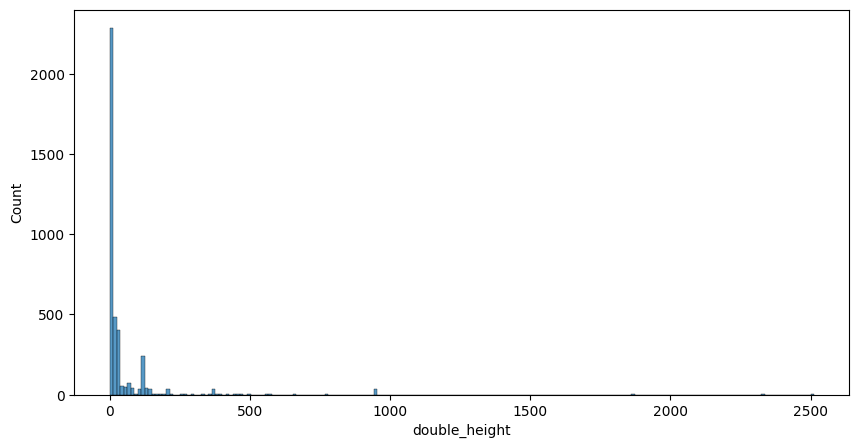

In [415]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ax=ax, data=df[df['double_height'] > 0], x="double_height", bins=200)

In [318]:
df['support_area_m2'] = df['support_area'] / df['slab_total_area']
df['support_column_m2'] = df['support_column'] / df['slab_total_area']

<AxesSubplot: xlabel='support_column_m2', ylabel='Count'>

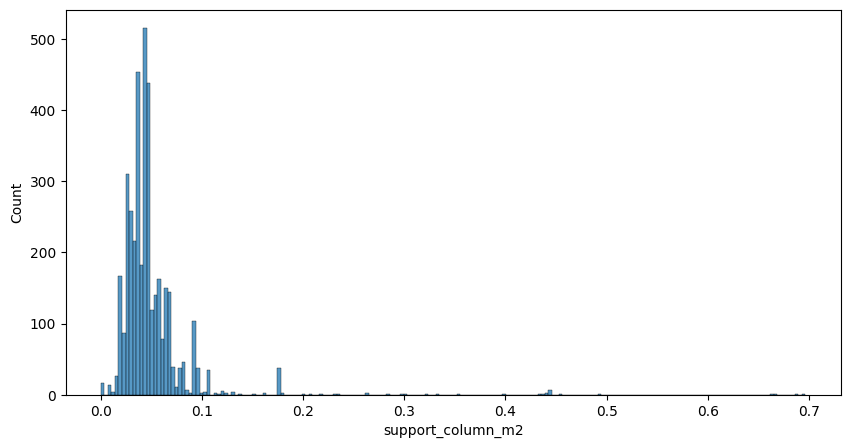

In [416]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ax=ax, data=df[df['double_height'] > 0], x="support_column_m2", bins=200)

In [408]:
df['is_double_height'] = (df['double_height_m2'] > 0.5).astype('category')

<AxesSubplot: xlabel='double_height_m2', ylabel='support_area_m2'>

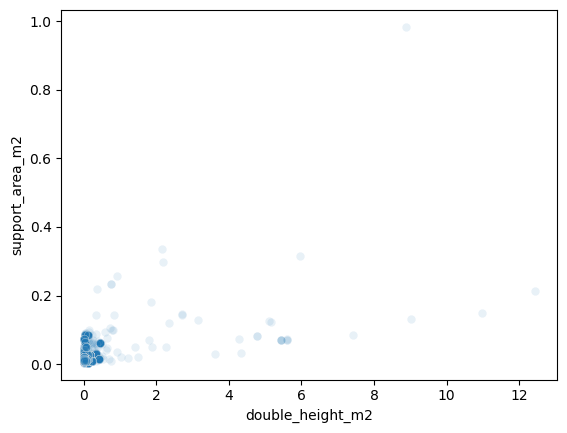

In [424]:
sns.scatterplot(data=df[df['double_height_m2'] > 0], x='double_height_m2', y='support_area_m2', alpha=0.1)

<AxesSubplot: xlabel='support_area_m2', ylabel='is_double_height'>

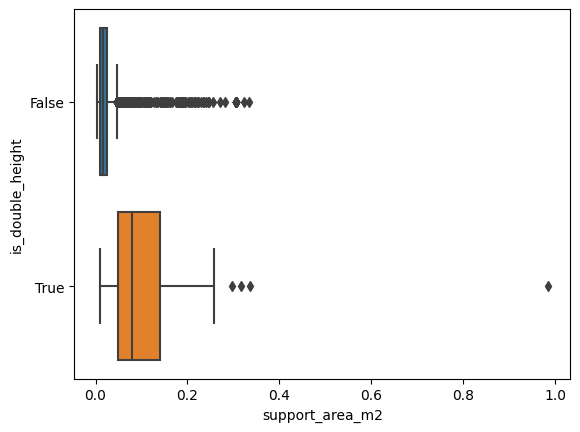

In [422]:
sns.boxplot(df, x='support_area_m2', y='is_double_height')

<AxesSubplot: xlabel='reinf_steel_ratio', ylabel='is_double_height'>

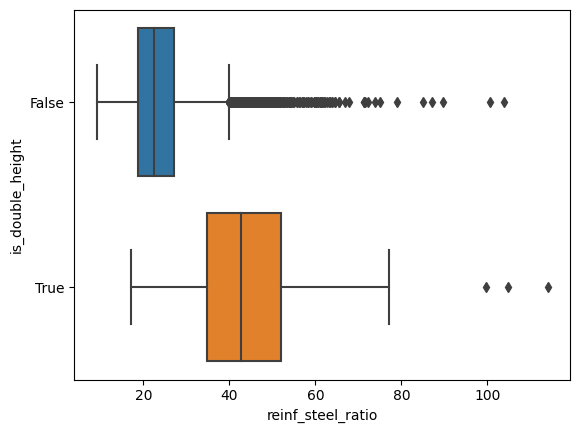

In [411]:
sns.boxplot(df, x='reinf_steel_ratio', y='is_double_height')

**double_height está mal calculado**:

In [402]:
df[df['project_code'] == 'BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01'][['floor_name', 'support_area_m2', 'slab_total_area', 'support_column', 'height', 'double_height']]

,floor_name,support_area_m2,slab_total_area,support_column,height,double_height
109,SEMISOTANO,0.047664,1139.824529,33,2.88,0.000000
110,"Semisotano 0,00",0.983568,55.605263,37,1.62,493.780879
111,PLANTA 1,0.011486,549.386142,37,1.44,0.000000
112,PLANTA 1A,0.072831,83.618552,37,1.44,467.876323
113,PLANTA 2,0.010952,551.494875,37,1.44,0.000000
114,PANTA 2A,0.071217,83.618102,37,1.44,455.334619
115,PLANTA 3,0.011049,538.952721,37,1.44,0.000000
116,PLANTA 3A,0.070439,83.618102,37,1.44,467.873744
117,PLANTA 4,0.010680,551.491845,37,1.44,0.000000
118,PLANTA 4A,0.070439,83.618102,37,1.44,455.334397


In [465]:
DH_M2_THRESHOLD = 0.2
TH_M2_THRESHOLD = 0.2

def fix_double_height(df):
    df['double_height'] = df.groupby(by='project_code')['slab_total_area'].shift(-1) - df['slab_total_area']
    df.loc[df['double_height'] < 0, 'double_height'] = 0
    df['double_height'] = df['double_height'].fillna(0)
    df['double_height_m2'] = df['double_height'] / df['slab_total_area']
    df.loc[df['double_height_m2'] < DH_M2_THRESHOLD, 'double_height'] = 0
    df['double_height_m2'] = df['double_height'] / df['slab_total_area']
    
def fix_triple_height(df):
    df['triple_height'] = df.groupby(by='project_code')['slab_total_area'].shift(-2) - df['slab_total_area']
    df.loc[df['triple_height'] < 0, 'triple_height'] = 0
    df['triple_height'] = df['triple_height'].fillna(0)
    df['triple_height_m2'] = df['triple_height'] / df['slab_total_area']
    df.loc[df['triple_height_m2'] < DH_M2_THRESHOLD, 'triple_height'] = 0
    df['triple_height_m2'] = df['triple_height'] / df['slab_total_area']

In [466]:
fix_double_height(df)
fix_triple_height(df)

In [467]:
df['is_double_height'] = (df['double_height'] > 0).astype('category')
df['is_triple_height'] = (df['triple_height'] > 0).astype('category')

<AxesSubplot: xlabel='reinf_steel_ratio', ylabel='is_double_height'>

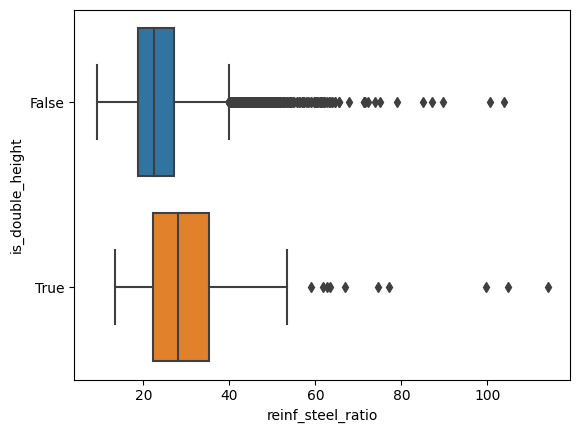

In [468]:
sns.boxplot(df, x='reinf_steel_ratio', y='is_double_height')

<AxesSubplot: xlabel='reinf_steel_ratio', ylabel='is_triple_height'>

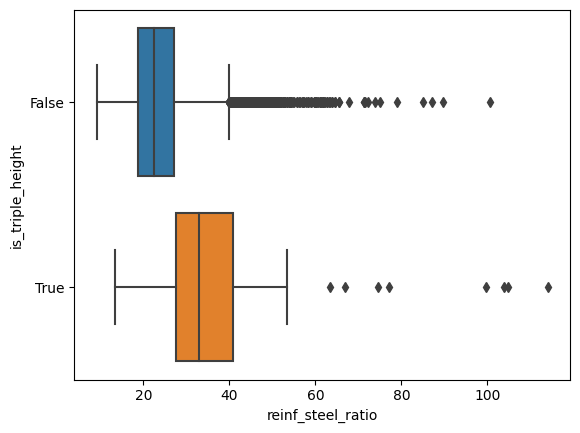

In [469]:
sns.boxplot(df, x='reinf_steel_ratio', y='is_triple_height')

In [470]:
(df['is_double_height'] == True).sum()

216

In [471]:
(df['is_triple_height'] == True).sum()

79

In [445]:
fields = ['project_code', 'floor_name', 'level', 'reinf_steel_ratio', 'slab_total_area', 
          'double_height_m2', 'triple_height_m2']
df[(df['double_height_m2'] < 0.2) & (df['triple_height_m2'] > 0.2) & (df['level'] > 0)][fields]

,project_code,floor_name,level,reinf_steel_ratio,slab_total_area,double_height_m2,triple_height_m2
175,BOLP15018_C00_I00_H00_Q00_R00_V00_S00_O01,Nivel 4,12.60,17.81,250.828098,0.000000,0.400466
1213,BOLP18005_C00_I00_H00_Q00_R00_V00_S00_O01,Planta 22,70.95,26.42,94.126225,0.000000,0.210793
8718,BOSC18003M2_C00_I00_H00_Q00_R00_V00_S00_O01,PISO 3,19.65,39.98,1532.577223,0.000000,0.252422
16151,PYAS18003_C00_I00_H00_Q00_R00_V00_S00_O01,Planta 02,2.80,22.45,418.173221,0.103373,1.458177
17658,PYAS19027M2_C00_I00_H00_Q00_R00_V00_S00_O01,PLANTA 1,4.00,23.76,1121.201273,0.060217,0.214776
17665,PYAS19027M3_C00_I00_H00_Q00_R00_V00_S00_O01,PLANTA 1,4.00,30.62,1162.061517,0.001440,0.257408
17720,PYAS19031_C00_I00_H00_Q00_R00_V00_S00_O02,Deck piscina,32.96,103.81,70.784444,0.000000,2.531678
19689,PYAS20034_C00_I00_H00_Q00_R00_V00_S00_O01,N4 +12.38m_EST 4.2,12.38,34.24,280.483182,0.000000,0.390814


In [444]:
df[df['project_code'] == 'BOLP15018_C00_I00_H00_Q00_R00_V00_S00_O01'][fields]

,project_code,floor_name,level,reinf_steel_ratio,slab_total_area,double_height_m2,triple_height_m2
171,BOLP15018_C00_I00_H00_Q00_R00_V00_S00_O01,Planta Baja,0.00,30.91,338.049030,0.000000,0.000000
172,BOLP15018_C00_I00_H00_Q00_R00_V00_S00_O01,Nivel 1,3.15,22.19,181.362238,0.383023,0.383023
173,BOLP15018_C00_I00_H00_Q00_R00_V00_S00_O01,Nivel 2,6.30,18.39,250.828098,0.000000,0.000000
174,BOLP15018_C00_I00_H00_Q00_R00_V00_S00_O01,Nivel 3,9.45,18.57,250.828098,0.000000,0.000000
175,BOLP15018_C00_I00_H00_Q00_R00_V00_S00_O01,Nivel 4,12.60,17.81,250.828098,0.000000,0.400466
176,BOLP15018_C00_I00_H00_Q00_R00_V00_S00_O01,Nivel 5,15.75,17.33,250.828098,0.400466,0.000000
177,BOLP15018_C00_I00_H00_Q00_R00_V00_S00_O01,Nivel 6,18.90,16.72,351.276098,0.000000,0.000000
178,BOLP15018_C00_I00_H00_Q00_R00_V00_S00_O01,Nivel 7,22.05,16.08,250.828098,0.000000,0.000000
179,BOLP15018_C00_I00_H00_Q00_R00_V00_S00_O01,Nivel 8,25.20,16.09,250.828098,0.000000,0.000000
180,BOLP15018_C00_I00_H00_Q00_R00_V00_S00_O01,Cubierta,28.35,18.33,103.406436,0.000000,0.000000


In [351]:
fix_double_height(df)

In [362]:
df['double_height_m2'] = df['double_height'] / df['slab_total_area']

<AxesSubplot: xlabel='double_height_m2', ylabel='Count'>

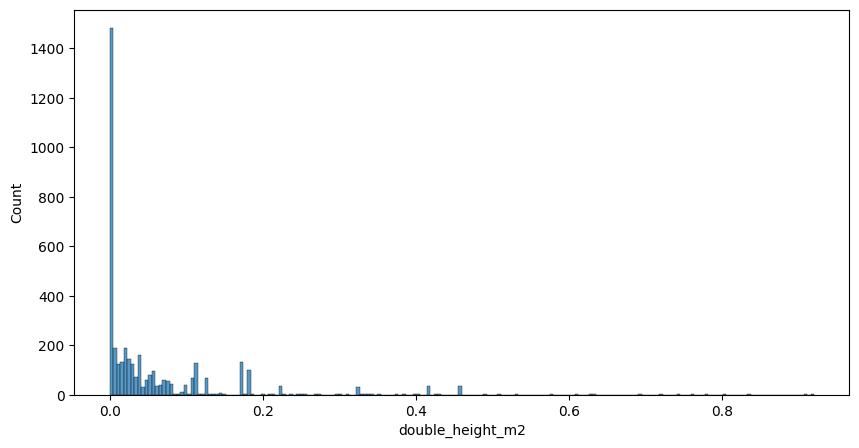

In [403]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ax=ax, data=df[(df['double_height_m2'] > 0) & (df['double_height_m2'] < 1)], x="double_height_m2", bins=200)

In [395]:
df[df['double_height_m2'] > 0.8][['project_code', 'floor_name', 'support_area_m2', 'slab_total_area', 'double_height_m2', 'height', 'double_height']]

,project_code,floor_name,support_area_m2,slab_total_area,double_height_m2,height,double_height
110,BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01,"Semisotano 0,00",0.983568,55.605263,8.880110,1.62,493.780879
112,BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01,PLANTA 1A,0.072831,83.618552,5.595365,1.44,467.876323
114,BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01,PANTA 2A,0.071217,83.618102,5.445407,1.44,455.334619
116,BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01,PLANTA 3A,0.070439,83.618102,5.595364,1.44,467.873744
118,BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01,PLANTA 4A,0.070439,83.618102,5.445405,1.44,455.334397
120,BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01,PLANTA 5A,0.070439,83.618102,5.595364,1.44,467.873744
122,BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01,PLANTA 6A,0.070439,83.618102,5.445405,1.44,455.334397
124,BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01,PLANTA 7A,0.070439,83.618102,5.445408,1.44,455.334659
299,BOLP16009_C00_I00_H00_Q00_R00_V00_S00_O01,MAQUINAS,0.118454,10.025000,2.350991,1.34,23.568680
304,BOLP16011_C00_I00_H00_Q00_R00_V00_S00_O01,P1,0.149905,36.422982,10.976130,2.70,399.783400


In [393]:
df[df['project_code'] == 'BOCB19002_C00_I00_H00_Q00_R00_V00_S00_O01'][['floor_name', 'support_area_m2', 'slab_total_area', 'support_column', 'height', 'double_height']]

,floor_name,support_area_m2,slab_total_area,support_column,height,double_height
0,NIVEL +3.5,0.010480,3292.093703,144,3.5,0.000000
1,NIVEL +7,0.024361,881.073190,71,3.5,0.000000
2,NIVEL +10,0.016079,215.658464,17,3.0,15.218476
3,NIVEL +13,0.015019,230.876940,17,3.0,0.000000


In [352]:
df[df['project_code'] == 'BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01'][['floor_name', 'support_area_m2', 'slab_total_area', 'support_column', 'height', 'double_height']]

,floor_name,support_area_m2,slab_total_area,support_column,height,double_height
109,SEMISOTANO,0.047664,1139.824529,33,2.88,0.000000
110,"Semisotano 0,00",0.983568,55.605263,37,1.62,493.780879
111,PLANTA 1,0.011486,549.386142,37,1.44,0.000000
112,PLANTA 1A,0.072831,83.618552,37,1.44,467.876323
113,PLANTA 2,0.010952,551.494875,37,1.44,0.000000
114,PANTA 2A,0.071217,83.618102,37,1.44,455.334619
115,PLANTA 3,0.011049,538.952721,37,1.44,0.000000
116,PLANTA 3A,0.070439,83.618102,37,1.44,467.873744
117,PLANTA 4,0.010680,551.491845,37,1.44,0.000000
118,PLANTA 4A,0.070439,83.618102,37,1.44,455.334397


In [328]:
df[df['project_code'] == 'BOLP16011_C00_I00_H00_Q00_R00_V00_S00_O01'][['floor_name', 'support_area_m2', 'slab_total_area', 'support_column', 'height']]

,floor_name,support_area_m2,slab_total_area,support_column,height
302,Forjado 1,0.050250,837.078702,25,2.70
303,SEMISÓTANO,0.081825,514.065546,25,2.88
304,P1,0.149905,36.422982,25,2.70
305,P2,0.011783,436.206382,25,2.70
306,P3,0.011508,436.206382,25,2.70
307,P4,0.010683,436.206257,25,2.70
308,P5,0.010202,436.206257,25,2.70
309,P6,0.010087,436.206257,25,2.70
310,P7,0.009972,436.206257,25,2.70
311,P8,0.009858,436.206257,25,2.70


## floor_number
Está bien.

In [537]:
(df.groupby(by='project_code')['floor_number'].count() != df.groupby(by='project_code')['floor_number'].last()).sum()

0

## Supports
### Number

In [473]:
support_col_num = ['support_column', 'unsupported_column', 'walls_number', 'retaining_walls_number']

In [475]:
df[support_col_num].describe()

,support_column,unsupported_column,walls_number,retaining_walls_number
count,21354.000000,21354.000000,21354.000000,21354.000000
mean,22.047345,1.087009,4.976211,0.538775
std,18.074184,4.177726,5.364623,2.306761
min,0.000000,0.000000,0.000000,0.000000
25%,12.000000,0.000000,0.000000,0.000000
50%,17.000000,0.000000,3.000000,0.000000
75%,28.000000,0.000000,8.000000,0.000000
max,328.000000,55.000000,91.000000,67.000000


array([[<AxesSubplot: title={'center': 'support_column'}>,
        <AxesSubplot: title={'center': 'unsupported_column'}>],
       [<AxesSubplot: title={'center': 'walls_number'}>,
        <AxesSubplot: title={'center': 'retaining_walls_number'}>]],
      dtype=object)

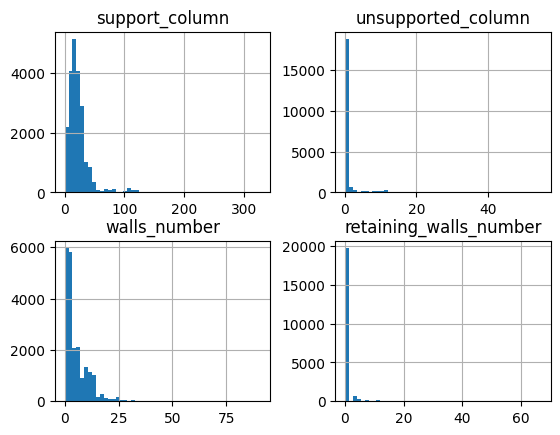

In [477]:
df[support_col_num].hist(bins=50)

In [479]:
df[(df['support_column'] == 0) & (df['walls_number'] == 0)][support_col_num]

,support_column,unsupported_column,walls_number,retaining_walls_number


### Áreas

In [482]:
support_col_areas = ['support_area', 'walls_area', 'retaining_walls_area']

In [483]:
df[support_col_areas].describe()

,support_area,walls_area,retaining_walls_area
count,21354.000000,21354.000000,21354.000000
mean,10.021789,5.425915,2.545696
std,12.113966,10.735951,9.679810
min,0.072800,0.000000,0.000000
25%,3.995584,0.000000,0.000000
50%,6.227238,1.571593,0.000000
75%,11.705000,5.025000,0.000000
max,194.335844,163.115844,116.765270


## Cargas

Los valores mínimo y máximo están bien.

In [484]:
load_fields = ['LL', 'DL', 'LL_max', 'DL_max', 'wind_load_x', 'wind_load_y', 'seismic_acc']

In [486]:
df[load_fields].describe()

,LL,DL,LL_max,DL_max,wind_load_x,wind_load_y,seismic_acc
count,21354.000000,21354.000000,21354.000000,21354.000000,21354.000000,21354.000000,21354.000000
mean,2.624531,1.933224,3.135228,3.484076,59.906503,68.189445,1.087363
std,1.121582,0.420987,1.742390,4.280382,53.969393,61.573784,0.768292
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,23.018000,23.609750,0.000000
50%,2.000000,2.000000,3.000000,2.000000,47.103500,51.345000,1.491120
75%,3.000000,2.000000,4.000000,2.500000,82.548000,97.975000,1.726560
max,28.500000,5.000000,28.500000,42.000000,796.813000,862.158000,3.080340


array([[<AxesSubplot: title={'center': 'LL'}>,
        <AxesSubplot: title={'center': 'DL'}>,
        <AxesSubplot: title={'center': 'LL_max'}>],
       [<AxesSubplot: title={'center': 'DL_max'}>,
        <AxesSubplot: title={'center': 'wind_load_x'}>,
        <AxesSubplot: title={'center': 'wind_load_y'}>],
       [<AxesSubplot: title={'center': 'seismic_acc'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

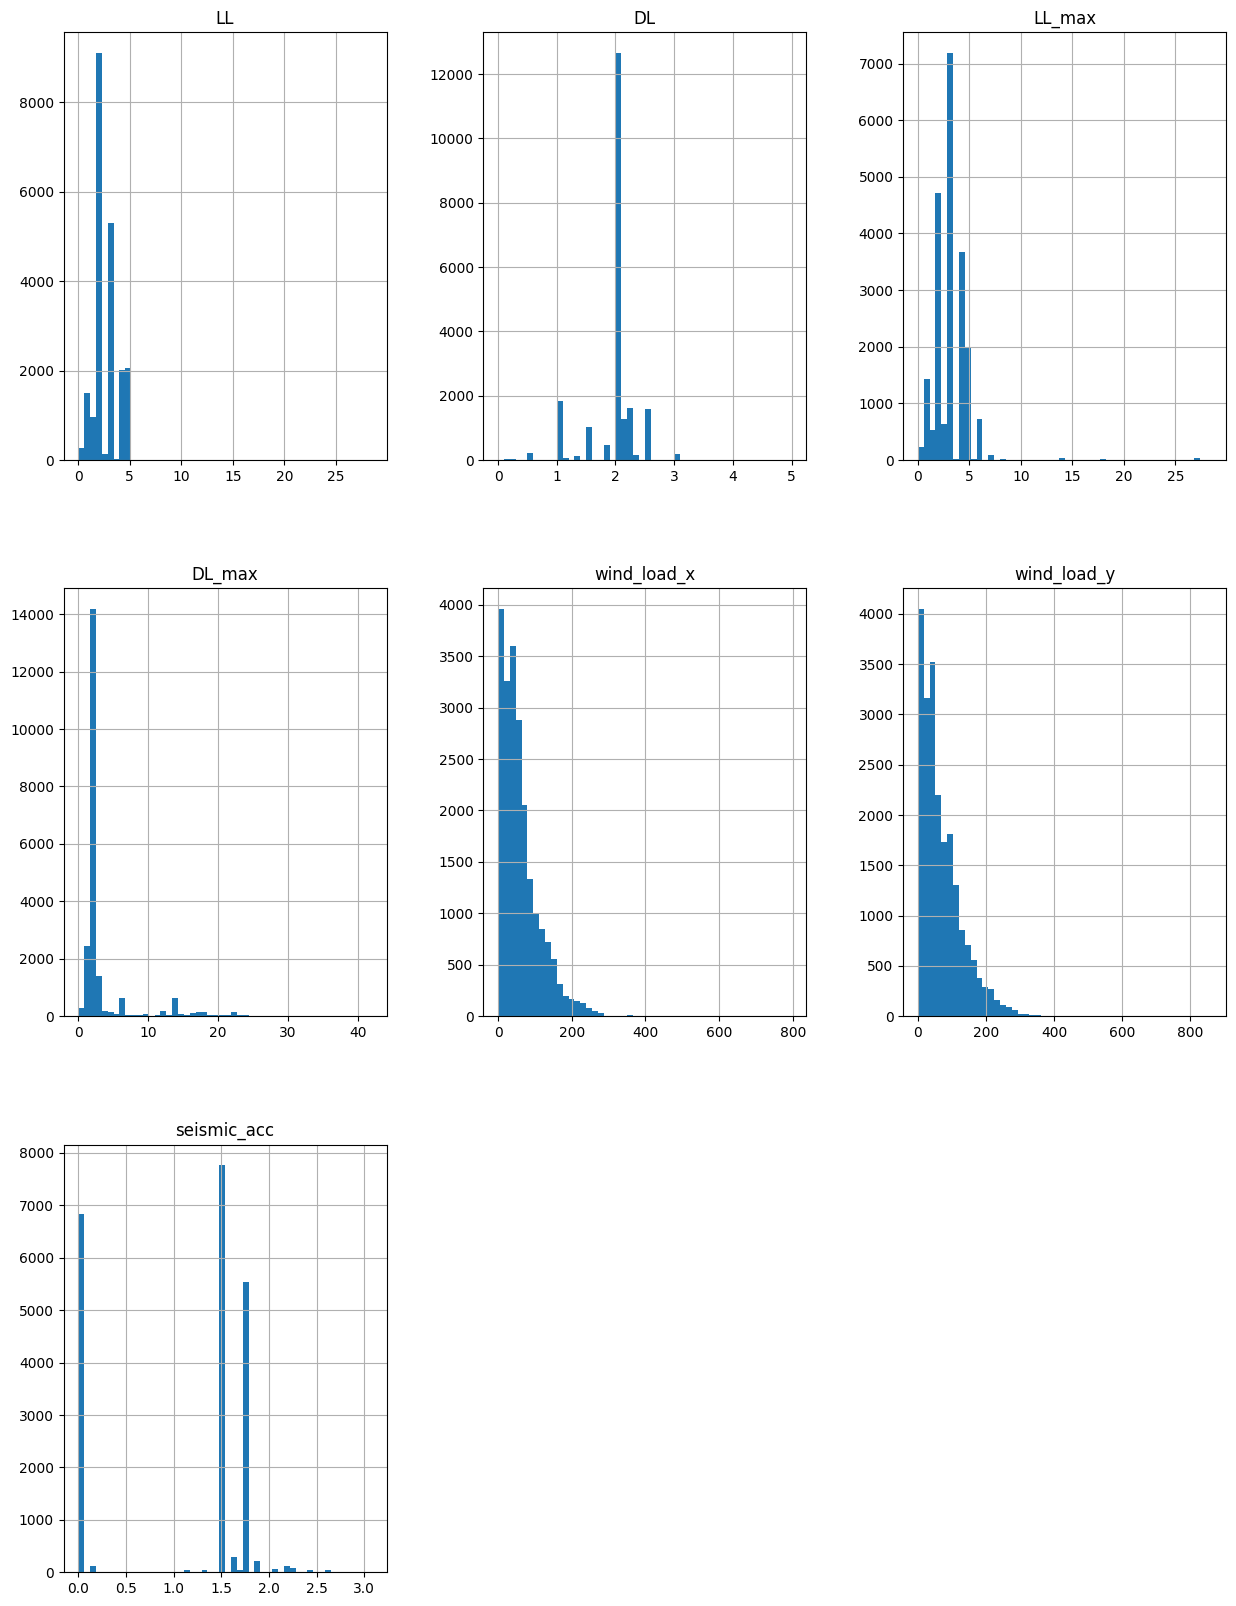

In [489]:
df[load_fields].hist(bins=50, figsize=(15, 20))

## Forma

**shape_factor** es el perímetro del forjado.

In [490]:
shape_fields = ['shape_factor', 'x_length', 'y_length']

In [497]:
df[shape_fields].sample(10)

,shape_factor,x_length,y_length
11128,58.929062,20.218881,9.245650
10234,36.074608,12.754300,12.754300
1538,100.796250,22.156700,32.850000
15492,56.887776,15.445000,11.061400
10334,130.440300,33.450900,26.711800
20930,59.534413,12.130328,16.725813
14962,110.991319,26.001600,23.000000
17614,95.961319,30.587500,18.949900
11406,59.534413,12.130328,16.725813
16773,96.418499,34.026400,14.278800


<AxesSubplot: >

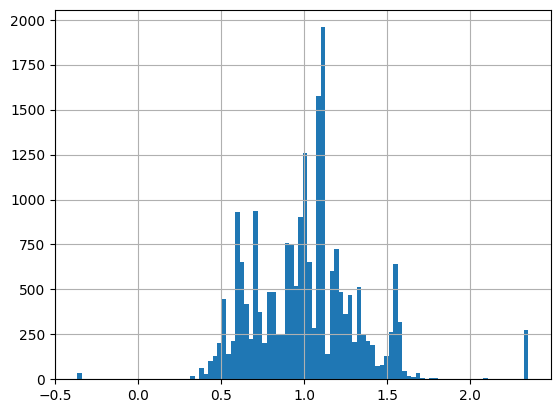

In [505]:
((df['shape_factor'] - 2*df['x_length'] + 2*df['y_length']) / (2*df['x_length'] + 2*df['y_length'])).hist(bins=100)

In [491]:
df[shape_fields].describe()

,shape_factor,x_length,y_length
count,21354.000000,21354.000000,21354.000000
mean,109.659987,27.170959,23.738991
std,55.059249,14.658731,11.566014
min,7.604000,1.901000,1.901000
25%,74.243342,16.999465,16.505800
50%,103.784233,24.173300,21.380100
75%,123.450848,32.895000,30.696925
max,813.841304,195.523300,103.956600


array([[<AxesSubplot: title={'center': 'shape_factor'}>,
        <AxesSubplot: title={'center': 'x_length'}>],
       [<AxesSubplot: title={'center': 'y_length'}>, <AxesSubplot: >]],
      dtype=object)

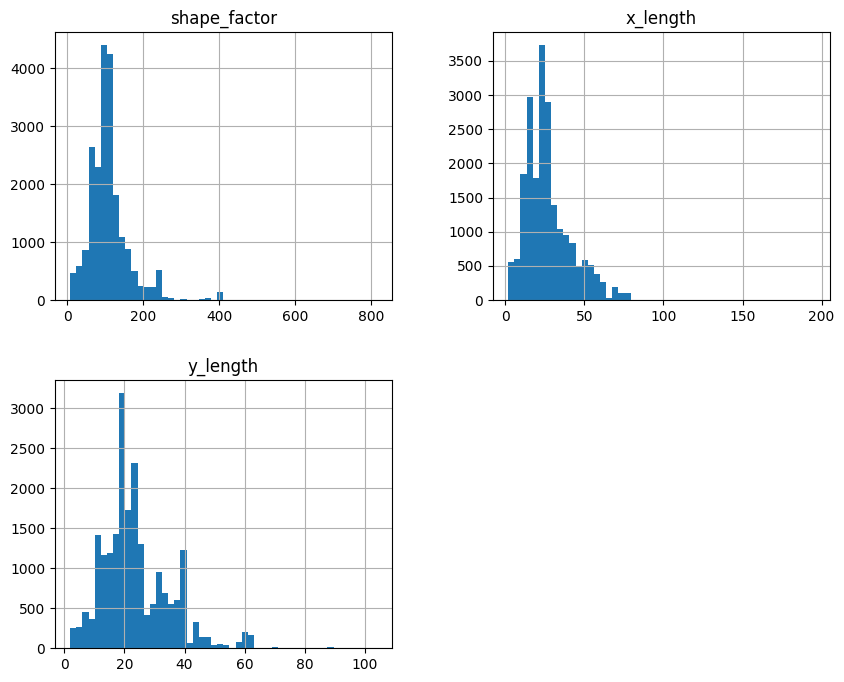

In [528]:
df[shape_fields].hist(bins=50, figsize=(10,8))

## Centros de masas y rigideces

> **OJO** Hay 78 proyecto (4 originales) que sus cdm y cdr están mal. Dan una excentricidad mayor de 25.

Algunos se debe a que son dobles alturas y entonces hay muchos pilares y por tanto mucha rigidez. Otros casos es debido a que hay un error en las unidades.

In [523]:
cog_fields = ['cdm_x','cdm_y', 'cdr_x', 'cdr_y', 'center_x', 'center_y']

In [524]:
df[cog_fields].describe()

,cdm_x,cdm_y,cdr_x,cdr_y,center_x,center_y
count,21354.000000,21354.000000,21354.000000,21354.000000,21354.000000,21354.000000
mean,27.170853,24.555420,32.252586,18.700000,32.361998,18.492607
std,50.497876,48.855554,59.344725,56.582327,59.366348,56.516699
min,-11.335640,-219.277082,-3.335378,-220.705068,-2.087616,-220.803849
25%,17.108432,16.527150,17.236065,14.978046,17.233854,14.850000
50%,23.353703,21.620117,23.574201,20.681318,24.097606,20.997800
75%,31.058217,30.748357,31.932776,29.388688,31.617020,29.496558
max,2154.969697,2057.109112,2154.969699,1789.539325,2154.969696,1789.047359


array([[<AxesSubplot: title={'center': 'cdm_x'}>,
        <AxesSubplot: title={'center': 'cdm_y'}>],
       [<AxesSubplot: title={'center': 'cdr_x'}>,
        <AxesSubplot: title={'center': 'cdr_y'}>],
       [<AxesSubplot: title={'center': 'center_x'}>,
        <AxesSubplot: title={'center': 'center_y'}>]], dtype=object)

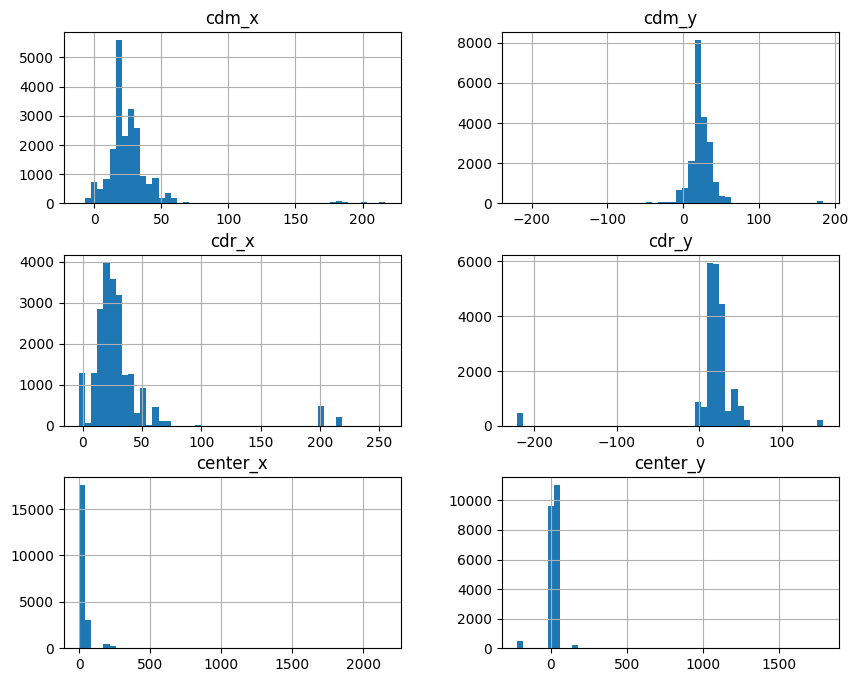

In [625]:
df[cog_fields].hist(bins=50, figsize=(10,8))

<AxesSubplot: >

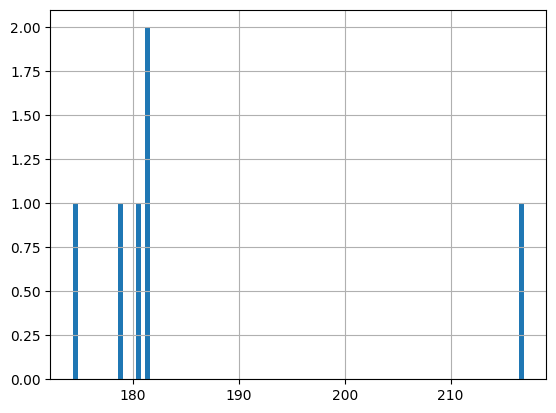

In [598]:
df[ori_cond & (df['cdm_x'] > 150) & (df['cdm_x'] < 300)]['cdm_x'].hist(bins=100)

In [629]:
df[ori_cond & (df['cdm_x'] > 150) & (
    df['cdm_x'] < 300)][['eccentricity_m2','eccentricity', 'floor_name', 'slab_total_area', 'x_length', 'y_length']+cog_fields]

,eccentricity_m2,eccentricity,floor_name,slab_total_area,x_length,y_length,cdm_x,cdm_y,cdr_x,cdr_y,center_x,center_y
17422,4.682059e-02,4.589897e+01,P1,980.315803,49.990194,25.560942,181.573983,177.609542,216.865752,148.263225,216.916838,149.441896
17423,4.682059e-02,4.589897e+01,P2,980.315803,49.990194,25.560942,181.573983,177.609542,216.865752,148.263225,216.916838,149.441896
17424,4.684022e-02,4.630301e+01,PH,988.531089,49.990194,25.560942,180.713399,177.163338,216.864039,148.230652,216.916838,149.441896
17425,4.256383e-02,4.679826e+01,TERRAZA,1099.484022,49.990194,25.560942,179.017094,175.850518,216.861657,148.321156,216.916838,149.441896
17426,1.135433e-01,4.840110e+01,TECHO TERRAZA,426.278677,41.495000,18.879208,174.358061,171.157854,216.924264,148.119094,216.918340,148.701072
17427,1.046243e-09,3.510002e-08,T.SUP.,33.548615,33.469555,3.274313,216.914618,150.283776,216.914618,150.283776,216.914618,150.283776


In [650]:
df['max_length'] = df[['x_length', 'y_length']].max(axis=1)

In [602]:
cog_cm_cond = df['cdm_x'] > 500
df.loc[cog_cm_cond, 'cdm_x'] /= 100
df.loc[cog_cm_cond, 'cdm_y'] /= 100
df.loc[cog_cm_cond, 'cdr_x'] /= 100
df.loc[cog_cm_cond, 'cdr_y'] /= 100

In [600]:
df[(df['cdm_x'] > 100)][
['eccentricity_m2','eccentricity', 'floor_name', 'slab_total_area', 'slab_type', 'reinf_steel_ratio']+cog_fields]

,eccentricity_m2,eccentricity,floor_name,slab_total_area,slab_type,reinf_steel_ratio,cdm_x,cdm_y,cdr_x,cdr_y,center_x,center_y
2924,0.047468,46.534044,P1,980.315803,FOAM_WAFFLE,20.09,179.965939,176.614963,216.865752,148.263225,216.916838,149.441896
2925,0.047468,46.534044,P2,980.315803,FOAM_WAFFLE,19.93,179.965939,176.614963,216.865752,148.263225,216.916838,149.441896
2926,0.047330,46.787181,PH,988.531089,FOAM_WAFFLE,19.06,179.422032,176.286604,216.864039,148.230652,216.916838,149.441896
2927,0.043405,47.722595,TERRAZA,1099.484022,FOAM_WAFFLE,21.19,176.410008,173.641308,216.861657,148.321156,216.916838,149.441896
2928,0.111800,47.657795,TECHO TERRAZA,426.278677,FOAM_WAFFLE,15.82,175.904751,172.381512,216.924264,148.119094,216.918340,148.701072
...,...,...,...,...,...,...,...,...,...,...,...,...
21714,0.027641,0.238890,Forjado 15,8.642649,FLAT_SLAB,28.40,198.852150,-219.277082,198.844421,-219.038318,198.859000,-219.493992
21729,0.027641,0.238890,Forjado 15,8.642649,FLAT_SLAB,29.47,198.852150,-219.277082,198.844421,-219.038318,198.859000,-219.493992
21744,0.027641,0.238890,Forjado 15,8.642649,FLAT_SLAB,29.71,198.852150,-219.277082,198.844421,-219.038318,198.859000,-219.493992
21759,0.027641,0.238890,Forjado 15,8.642649,FLAT_SLAB,29.00,198.852150,-219.277082,198.844421,-219.038318,198.859000,-219.493992


In [668]:
df['eccentricity'] = ((df['cdm_x'] - df['cdr_x'])*(df['cdm_x'] - df['cdr_x']) + 
                      (df['cdm_y'] - df['cdr_y']) * (df['cdm_y'] - df['cdr_y']))**0.5

<AxesSubplot: >

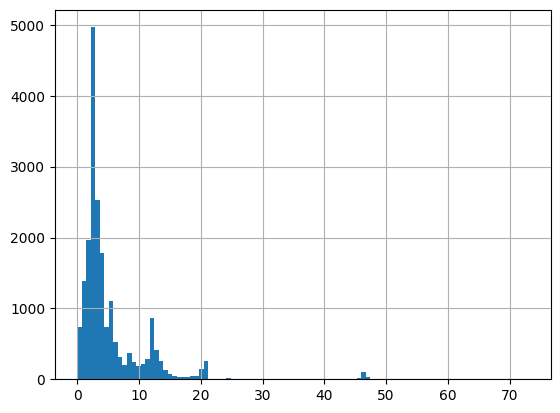

In [670]:
df[(df['slab_type'] == 'FOAM_WAFFLE')]['eccentricity'].hist(bins=100)

<AxesSubplot: >

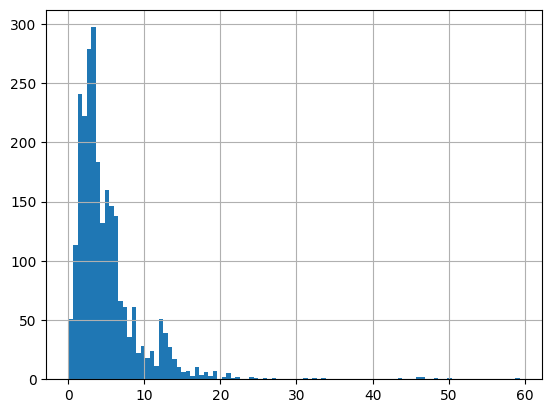

In [636]:
df[ori_cond & (df['slab_type'] == 'FOAM_WAFFLE')]['eccentricity'].hist(bins=100)

In [671]:
df['eccentricity_length'] = df['eccentricity'] / df['max_length']

<AxesSubplot: >

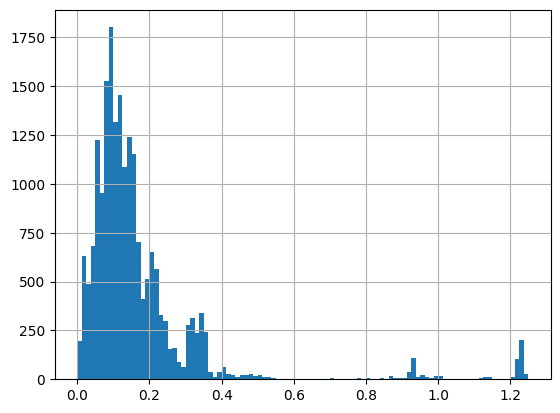

In [672]:
df[(df['slab_type'] == 'FOAM_WAFFLE')]['eccentricity_length'].hist(bins=100)

In [667]:
cog_cm_cond = df['eccentricity_length'] > 2
df.loc[cog_cm_cond, 'cdm_x'] /= 100
df.loc[cog_cm_cond, 'cdm_y'] /= 100
df.loc[cog_cm_cond, 'cdr_x'] /= 100
df.loc[cog_cm_cond, 'cdr_y'] /= 100

In [666]:
df[(df['slab_type'] == 'FOAM_WAFFLE') & (df['eccentricity_length'] > 2)][
    ['project_code','eccentricity_length','max_length','eccentricity', 'floor_name', 'slab_total_area']+cog_fields]

,project_code,eccentricity_length,max_length,eccentricity,floor_name,slab_total_area,cdm_x,cdm_y,cdr_x,cdr_y,center_x,center_y
6602,BOLP20407_C01_I01_H01_Q01_R08_V04_S05_O01,9.317354,27.566987,256.851386,Forjado 1,439.373528,-6.425764,-69.614572,202.116047,-219.557720,203.223129,-217.297379
6603,BOLP20407_C01_I01_H01_Q01_R08_V04_S05_O01,9.034520,29.017841,262.162257,Forjado 2,433.458698,-10.706122,-66.137725,201.556628,-219.999916,201.689513,-218.506109
6604,BOLP20407_C01_I01_H01_Q01_R08_V04_S05_O01,10.663570,24.425031,260.458019,Forjado 3,367.985105,-7.142440,-64.752472,201.465248,-220.705068,201.689606,-220.802479
6605,BOLP20407_C01_I01_H01_Q01_R08_V04_S05_O01,10.684567,24.422350,260.942233,Forjado 4,339.178512,-5.320969,-61.192792,201.528624,-220.265401,201.691138,-220.803842
6606,BOLP20407_C01_I01_H01_Q01_R08_V04_S05_O01,10.755091,24.422350,262.664607,Forjado 5,339.152287,-9.109189,-62.967439,201.303386,-220.190987,201.691138,-220.803842
...,...,...,...,...,...,...,...,...,...,...,...,...
21769,PYAS20407_C11_I01_H09_Q01_R04_V08_S00_O01,11.852936,22.722350,269.326563,Forjado 10,230.424416,45.919899,0.281982,200.929913,-219.964909,202.229847,-220.155775
21770,PYAS20407_C11_I01_H09_Q01_R04_V08_S00_O01,11.851664,22.722350,269.297669,Forjado 11,230.420291,43.421089,-1.469038,200.828430,-219.973416,202.229847,-220.155775
21771,PYAS20407_C11_I01_H09_Q01_R04_V08_S00_O01,11.886103,22.722350,270.080204,Forjado 12,230.410917,42.899055,-0.785862,200.733038,-219.947334,202.229847,-220.155775
21772,PYAS20407_C11_I01_H09_Q01_R04_V08_S00_O01,12.024174,22.422350,269.610254,Forjado 13,221.737443,43.771556,-0.702397,200.644109,-219.975494,201.879206,-219.803854


In [665]:
df[(df['project_code'] == 'BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01')][
    ['project_code','eccentricity_length','max_length','eccentricity', 'floor_name', 'slab_total_area', 'reinf_steel_ratio']]

,project_code,eccentricity_length,max_length,eccentricity,floor_name,slab_total_area,reinf_steel_ratio
109,BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01,0.169775,44.0890,7.485227,SEMISOTANO,1139.824529,44.25
110,BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01,0.284651,12.2027,3.473516,"Semisotano 0,00",55.605263,104.86
111,BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01,0.243092,32.6551,7.938184,PLANTA 1,549.386142,13.34
112,BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01,0.696387,14.1632,9.863066,PLANTA 1A,83.618552,52.55
113,BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01,0.250667,32.6551,8.185551,PLANTA 2,551.494875,15.91
114,BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01,0.709300,14.1632,10.045951,PANTA 2A,83.618102,45.70
115,BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01,0.249561,32.6551,8.149453,PLANTA 3,538.952721,17.01
116,BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01,0.709282,14.1632,10.045707,PLANTA 3A,83.618102,43.26
117,BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01,0.255201,32.6551,8.333614,PLANTA 4,551.491845,15.41
118,BOLP14017_C00_I00_H00_Q00_R00_V00_S00_O01,0.709282,14.1632,10.045707,PLANTA 4A,83.618102,42.14


In [634]:
df[ori_cond & (df['eccentricity'] > 30) & (df['eccentricity'] < 100)][
    ['eccentricity_m2','eccentricity', 'floor_name', 'slab_total_area', 'x_length', 'y_length']+cog_fields]

,eccentricity_m2,eccentricity,floor_name,slab_total_area,x_length,y_length,cdm_x,cdm_y,cdr_x,cdr_y,center_x,center_y
0,0.018014,59.302921,NIVEL +3.5,3292.093703,195.523300,31.000000,66.153262,57.826738,112.821181,21.235185,116.622403,20.353500
1,0.056810,50.053868,NIVEL +7,881.073190,188.661200,31.000000,78.419039,64.567056,105.177743,22.266211,108.302400,20.353500
8453,0.007276,31.192562,Forjado 1 (+1.50),4287.058295,137.562500,54.548100,62.581412,58.412859,92.711142,50.339734,78.951163,35.149939
8455,0.008719,32.231089,Forjado 3 (+4.90),3696.673550,130.359000,50.201100,60.571224,56.929689,92.167703,50.565287,75.243739,31.303493
8457,0.007966,33.325879,Forjado 5 (+8.30),4183.553758,129.909000,54.893700,60.811329,57.628873,91.931618,45.706549,74.932900,34.992850
8458,0.052399,43.781079,Cubierta (cota variable),835.534190,102.026700,66.125000,56.218363,51.060511,99.986241,49.985435,60.190441,40.355988
17422,0.046821,45.898968,P1,980.315803,49.990194,25.560942,181.573983,177.609542,216.865752,148.263225,216.916838,149.441896
17423,0.046821,45.898968,P2,980.315803,49.990194,25.560942,181.573983,177.609542,216.865752,148.263225,216.916838,149.441896
17424,0.046840,46.303014,PH,988.531089,49.990194,25.560942,180.713399,177.163338,216.864039,148.230652,216.916838,149.441896
17425,0.042564,46.798256,TERRAZA,1099.484022,49.990194,25.560942,179.017094,175.850518,216.861657,148.321156,216.916838,149.441896


In [614]:
df[ori_cond & (df['eccentricity_m2'] > 0.2) & (df['slab_type'] == 'FOAM_WAFFLE')]['project_code'].unique()

array(['PYAS20022_C00_I00_H00_Q00_R00_V00_S00_O01'], dtype=object)

In [615]:
df[(df['project_code'] == 'PYAS20022_C00_I00_H00_Q00_R00_V00_S00_O01')][
    ['eccentricity_m2','eccentricity', 'floor_name', 'slab_total_area', 'slab_type', 'reinf_steel_ratio']+cog_fields]

,eccentricity_m2,eccentricity,floor_name,slab_total_area,slab_type,reinf_steel_ratio,cdm_x,cdm_y,cdr_x,cdr_y,center_x,center_y
19059,0.004934,3.692930,PB,748.489395,FOAM_WAFFLE,28.85,27.188967,25.814451,29.362511,22.828913,29.793282,22.936104
19060,0.022331,13.533103,NIVEL 01,606.013528,FOAM_WAFFLE,40.39,31.542219,30.766114,36.927665,18.350726,33.694170,21.004814
19061,0.019994,12.117585,NIVEL 02,606.047611,FOAM_WAFFLE,21.91,28.967397,27.449411,37.221643,18.577924,33.694170,21.004814
19062,0.020538,12.447200,NIVEL 03,606.047611,FOAM_WAFFLE,20.27,28.943743,27.462092,37.371471,18.302061,33.694170,21.004814
19063,0.020851,12.636573,NIVEL 04,606.047611,FOAM_WAFFLE,19.91,28.927810,27.465239,37.412753,18.101013,33.694170,21.004814
19064,0.021434,12.989445,NIVEL 05,606.009530,FOAM_WAFFLE,19.73,28.851486,27.406277,37.769793,17.962259,33.694170,21.004814
19065,0.021658,13.124815,NIVEL 06,606.009530,FOAM_WAFFLE,19.46,28.852872,27.390206,37.932567,17.912871,33.694170,21.004814
19066,0.022515,13.524966,TERRAZA,600.707023,FOAM_WAFFLE,22.79,28.773214,27.284181,38.334800,17.718576,33.694170,21.004814
19067,0.239620,9.459668,ENTREPISO,39.477849,FOAM_WAFFLE,39.35,35.395809,26.098549,38.758634,17.256789,38.346704,18.083900
19068,0.056945,13.852327,TECHOS,243.259641,FOAM_WAFFLE,17.76,29.330854,27.291253,38.876797,17.253229,34.993883,18.706241


In [539]:
df[(df['eccentricity'] >  40) & (df['eccentricity'] < 50)][cog_fields]

,cdm_x,cdm_y,cdr_x,cdr_y,center_x,center_y
2371,80.619811,76.557631,113.195941,44.137743,118.973230,45.916810
2924,179.965939,176.614963,216.865752,148.263225,216.916838,149.441896
2925,179.965939,176.614963,216.865752,148.263225,216.916838,149.441896
2926,179.422032,176.286604,216.864039,148.230652,216.916838,149.441896
2927,176.410008,173.641308,216.861657,148.321156,216.916838,149.441896
...,...,...,...,...,...,...
17488,188.117461,184.657593,216.865752,148.263225,216.916838,149.441896
17489,188.117461,184.657593,216.865752,148.263225,216.916838,149.441896
17490,187.336081,184.247454,216.864039,148.230652,216.916838,149.441896
17491,184.621261,181.600217,216.861657,148.321156,216.916838,149.441896


In [533]:
df[ori_cond & (df['eccentricity'] >  200)][cog_fields]

,cdm_x,cdm_y,cdr_x,cdr_y,center_x,center_y
18908,2087.311018,2004.832089,2152.996114,1787.611765,2153.196683,1787.862965
18909,2074.982998,2057.109112,2151.929606,1789.057799,2152.424809,1788.925180
18910,2006.387077,1961.130478,2151.541095,1789.539325,2151.680982,1789.047359
18911,2005.662799,1961.989278,2151.572843,1789.523482,2151.680982,1789.047359
18912,2002.319509,1960.512447,2151.736194,1789.505565,2151.680982,1789.047359
18913,1998.965349,1959.389709,2151.745660,1789.468900,2151.742026,1789.046998
18914,2006.187933,1970.940855,2150.283111,1789.353052,2150.540040,1789.037116
18915,2005.258745,1972.095224,2150.160272,1789.327371,2150.540040,1789.037116
18916,1993.968707,1957.241730,2150.041103,1789.316990,2150.540715,1788.031906


In [520]:
len(df[(df['eccentricity'] >  25)]['project_code'].unique())

78

In [472]:
df.columns.tolist()

['floor_name',
 'version',
 'project_code',
 'floor_code',
 'software',
 'slab_type',
 'depth',
 'floor_number',
 'total_height',
 'level',
 'height',
 'floor_max_height',
 'floor_min_height',
 'foundation_height',
 'max_height_all_floors',
 'min_height_all_floors',
 'support_column',
 'unsupported_column',
 'walls_number',
 'retaining_walls_number',
 'inter_axis_distance',
 'LL',
 'DL',
 'LL_max',
 'DL_max',
 'wind_load_x',
 'wind_load_y',
 'seismic_acc',
 'total_area',
 'double_height',
 'flat_slab_area',
 'waffle_slab_area',
 'drop_panel_area',
 'domes_area',
 'support_area',
 'shape_factor',
 'x_length',
 'y_length',
 'inertia_x',
 'inertia_y',
 'local_slenderness_x',
 'local_slenderness_y',
 'total_slenderness_x',
 'total_slenderness_y',
 'stair_area',
 'slope_area',
 'walls_area',
 'retaining_walls_area',
 'foundation_type',
 'concrete_m3_ratio',
 'reinf_steel_ratio',
 'struc_steel_ratio',
 'domes_number',
 'deflection_ratio',
 'elasticiti_modulii',
 'cdm_x',
 'cdm_y',
 'cdm_x_m_

<AxesSubplot: xlabel='reinf_steel_ratio', ylabel='Count'>

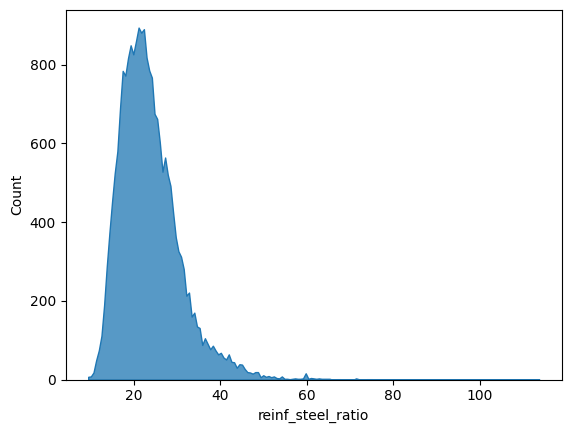

In [685]:
sns.histplot(df, x="reinf_steel_ratio", element="poly")

<AxesSubplot: xlabel='eccentricity_m2', ylabel='reinf_steel_ratio'>

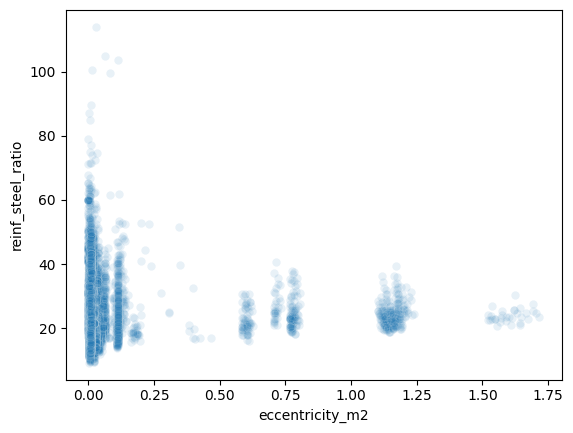

In [696]:
sns.scatterplot(data=df, x='eccentricity_m2', y='reinf_steel_ratio', alpha=0.1)